## DEBUG LOG

- Version 9: Used RMSE as a loss function. Gradcam looks generally on point.
- Version 10: Used BCE as a loss function. Gradcam looks horrendous.

## Flags

In [ ]:
# Whether this notebook is inference mode or not
is_inference = False

# Whether to normalize target from [0,100] to [0,1]
is_normalize_target = True

## Dependencies

In [ ]:
if not is_inference:
    !pip install -q torch-summary==1.4.5
    !pip install -q timm
    !pip install -q --upgrade wandb
    !pip install -q grad-cam==1.3.3
    !pip install -q torch-lr-finder==0.2.1
else:
    import sys
    sys.path.append("../input/timm-pytorch-image-models/pytorch-image-models-master")
    sys.path.append("../input/reighns-gradcam/pytorch-grad-cam-master")
    sys.path.append("../input/reighns-ttach/ttach-master")

In [ ]:
import collections
import gc
import os
import random
import warnings
from collections import defaultdict
from dataclasses import asdict, dataclass, field
from typing import *

import numpy as np
import pandas as pd
import timm
import torch

## Configurations

### Config class

We create a `config` class to create directories and store some initialization parameters. Note this `config` class does not store any information of the training process.

---

Calling `config` will then create the folders. You can simply go check if the folders are indeed created in the `output` directory of Kaggle.

Even if you do not call `config` explicitly, it will also create the folders for you if you are using a script. 
```python
import config # will initialize the process
```

In [ ]:
from pathlib import Path
import pathlib

class config:
    warnings.filterwarnings("ignore", category=UserWarning)
    # Need to change in local path
    DATA_DIR = Path("../input/petfinder-pawpularity-score")
    OUTPUT_DIR = Path("./")
    LOGS_DIR = Path(OUTPUT_DIR, "logs")
    MODEL_DIR = Path(OUTPUT_DIR, "model")
    OOF_DIR = Path(OUTPUT_DIR, "oof")
    LOGS_DIR.mkdir(parents=True, exist_ok=True)
    MODEL_DIR.mkdir(parents=True, exist_ok=True)
    OOF_DIR.mkdir(parents=True, exist_ok=True)
    
config

### Logger

Instead of simply printing, we can create a logger to log your bugs, info into a file. This is important when debugging too!

In [ ]:
from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger
import logging

def init_logger(log_file: str = Path(config.LOGS_DIR, "info.log")) -> logging.Logger:
    """Initialize logger and save to file.

    Consider having more log_file paths to save, eg: debug.log, error.log, etc.

    Args:
        log_file (str, optional): [description]. Defaults to Path(LOGS_DIR, "info.log").

    Returns:
        logging.Logger: [description]
    """
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    stream_handler = StreamHandler()
    stream_handler.setFormatter(
        Formatter("%(asctime)s: %(message)s", "%Y-%m-%d %H:%M:%S")
    )
    file_handler = FileHandler(filename=log_file)
    file_handler.setFormatter(
        Formatter("%(asctime)s: %(message)s", "%Y-%m-%d %H:%M:%S")
    )
    logger.addHandler(stream_handler)
    logger.addHandler(file_handler)

    return logger

In [ ]:
config.logger = init_logger()

### Device

Whether we are using GPU or CPU?

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config.logger.info(f"We are using {device}")

### Global Parameters

This part is where one store all their parameters, I partitioned parameters into different dataclasses object.

As an example, `ModelParams`, just like its name, handles primarily the parameters inside a model, be it default or tunable params. Note that there might be overlap in terms of the parameters.

---

**PLEASE UNHIDE CELL BELOW TO MAKE CHANGES TO THE GLOBAL PARAMETERS!**

In [ ]:
from dataclasses import dataclass, field, asdict
import pathlib
from typing import Any, Dict, List
import wandb


@dataclass
class FilePaths:
    """Class to keep track of the files."""

    train_images: pathlib.Path = pathlib.Path(config.DATA_DIR, "train")
    test_images: pathlib.Path = pathlib.Path(config.DATA_DIR, "test")
    train_csv: pathlib.Path = pathlib.Path(config.DATA_DIR, "train.csv")
    test_csv: pathlib.Path = pathlib.Path(config.DATA_DIR, "test.csv")
    sub_csv: pathlib.Path = pathlib.Path(
        config.DATA_DIR, "sample_submission.csv"
    )
    folds_csv: pathlib.Path = pathlib.Path(config.OUTPUT_DIR, "df_folds.csv")
    weight_path: pathlib.Path = pathlib.Path(config.MODEL_DIR)
    oof_csv: pathlib.Path = pathlib.Path(config.OOF_DIR)

    def to_dict(self) -> Dict[str, Any]:
        """Convert to dictionary."""
        return asdict(self)


@dataclass
class DataLoaderParams:
    """Class to keep track of the data loader parameters."""

    train_loader: Dict[str, Any] = field(
        default_factory=lambda: {
            "batch_size": 32,
            "num_workers": 4,
            "pin_memory": False,
            "drop_last": True,
            "shuffle": True,
            "collate_fn": None,
        }
    )
    valid_loader: Dict[str, Any] = field(
        default_factory=lambda: {
            "batch_size": 32,
            "num_workers": 4,
            "pin_memory": False,
            "drop_last": False,
            "shuffle": False,
            "collate_fn": None,
        }
    )

    test_loader: Dict[str, Any] = field(
        default_factory=lambda: {
            "batch_size": 8,
            "num_workers": 0,
            "pin_memory": True,
            "drop_last": False,
            "shuffle": False,
            "collate_fn": None,
        }
    )

    def to_dict(self) -> Dict[str, Any]:
        """Convert to dictionary."""
        return asdict(self)

    def get_len_train_loader(self):
        total_rows = pd.read_csv(FilePaths().train_csv).shape[
            0
        ]  # get total number of rows/images
        total_rows_per_fold = total_rows / (MakeFolds().num_folds)
        total_rows_per_training = total_rows_per_fold * (
            MakeFolds().num_folds - 1
        )  # if got 1000 images, 10 folds, then train on 9 folds = 1000/10 * (10-1) = 100 * 9 = 900
        len_of_train_loader = (
            total_rows_per_training // self.train_loader["batch_size"]
        )  # if 900 rows, bs is 16, then 900/16 = 56.25, but we drop last if dataloader, so become 56 steps. if not 57 steps.
        return int(len_of_train_loader)


@dataclass
class MakeFolds:
    """A class to keep track of cross-validation schema.
    seed (int): random seed for reproducibility.
    num_folds (int): number of folds.
    cv_schema (str): cross-validation schema.
    class_col_name (str): name of the target column.
    image_col_name (str): name of the image column.
    folds_csv (str): path to the folds csv.
    """

    seed: int = 1992
    num_folds: int = 5
    cv_schema: str = "StratifiedKFold"
    class_col_name: str = "Pawpularity"
    image_col_name: str = "Id"
    folds_csv: pathlib.Path = FilePaths().folds_csv

    def to_dict(self) -> Dict[str, Any]:
        """Convert to dictionary."""
        return asdict(self)


@dataclass
class AugmentationParams:
    """Class to keep track of the augmentation parameters."""

    mean: List[float] = field(default_factory=lambda: [0.485, 0.456, 0.406])
    std: List[float] = field(default_factory=lambda: [0.229, 0.224, 0.225])
    image_size: int = 224
    mixup: bool = True
    mixup_params: Dict[str, Any] = field(
        default_factory=lambda: {"mixup_alpha": 0.2, "use_cuda": True}
    )

    def to_dict(self) -> Dict[str, Any]:
        """Convert to dictionary."""
        return asdict(self)


@dataclass
class CriterionParams:
    """A class to track loss function parameters."""

    train_criterion_name: str = "BCEWithLogitsLoss"
    valid_criterion_name: str = "BCEWithLogitsLoss"
    train_criterion_params: Dict[str, Any] = field(
        default_factory=lambda: {
            "weight": None,
            "reduction": "mean",
            "pos_weight": None,
        }
    )
    valid_criterion_params: Dict[str, Any] = field(
        default_factory=lambda: {
            "weight": None,
            "reduction": "mean",
            "pos_weight": None,
        }
    )


@dataclass
class ModelParams:
    """A class to track model parameters.
    model_name (str): name of the model.
    pretrained (bool): If True, use pretrained model.
    input_channels (int): RGB image - 3 channels or Grayscale 1 channel
    output_dimension: Final output neuron.
                      It is the number of classes in classification.
                      Caution: If you use sigmoid layer for Binary, then it is 1.
    """

    model_name: str = "swin_large_patch4_window7_224"
    pretrained: bool = True
    input_channels: int = 3
    output_dimension: int = 1
    classification_type: str = ""

    def to_dict(self) -> Dict[str, Any]:
        """Convert to dictionary."""
        return asdict(self)

    def check_dimension(self) -> None:
        """Check if the output dimension is correct."""
        if (
            self.classification_type == "binary"
            and CriterionParams().train_criterion_name == "BCEWithLogitsLoss"
        ):
            assert self.output_dimension == 1, "Output dimension should be 1"
        elif self.classification_type == "multilabel":
            config.logger.info(
                "Check on output dimensions as we are likely using BCEWithLogitsLoss"
            )


@dataclass
class GlobalTrainParams:
    debug: bool = False
    debug_multipler: int = 16
    epochs: int = 6  # 6
    mixup: bool = AugmentationParams().mixup
    patience: int = 3
    model_name: str = ModelParams().model_name
    num_classes: int = ModelParams().output_dimension
    classification_type: str = ModelParams().classification_type
    use_amp: bool = True

    def to_dict(self) -> Dict[str, Any]:
        """Convert to dictionary."""
        return asdict(self)


@dataclass
class OptimizerParams:
    """A class to track optimizer parameters.
    optimizer_name (str): name of the optimizer.
    lr (float): learning rate.
    weight_decay (float): weight decay.
    """

    optimizer_name: str = "AdamW"
    optimizer_params: Dict[str, Any] = field(
        default_factory=lambda: {
            "lr": 5e-5,
            "betas": (0.9, 0.999),
            "amsgrad": False,
            "weight_decay": 1e-3,
            "eps": 1e-08,
        }
    )

    def to_dict(self) -> Dict[str, Any]:
        """Convert to dictionary."""
        return asdict(self)


@dataclass
class SchedulerParams:
    """A class to track Scheduler Params."""

    scheduler_name: str = "OneCycleLR"
    if scheduler_name == "OneCycleLR":
        scheduler_params: Dict[str, Any] = field(
            default_factory=lambda: {
                "max_lr": 3e-5,
                "steps_per_epoch": DataLoaderParams().get_len_train_loader(),
                "epochs": GlobalTrainParams().epochs,
                "pct_start": 0.3,
                "anneal_strategy": "cos",
                "div_factor": 25, # default is 25
                "three_phase": False,
                "last_epoch": -1,
            }
        )

    elif scheduler_name == "CosineAnnealingWarmRestarts":
        scheduler_params: Dict[str, Any] = field(
            default_factory=lambda: {
                "T_0": 10,
                "T_mult": 1,
                "eta_min": 1e-4,
                "last_epoch": -1,
            }
        )

    def to_dict(self) -> Dict[str, Any]:
        """Convert to dictionary."""
        return asdict(self)


@dataclass
class WandbParams:
    """A class to track wandb parameters."""

    project: str = "Petfinder"
    entity: str = "reighns"
    save_code: bool = True
    job_type: str = "Train"
    # add an unique group id behind group name.
    group: str = f"{GlobalTrainParams().model_name}_{MakeFolds().num_folds}_folds_{wandb.util.generate_id()}"
    # dir: str = "./wandb"

    def to_dict(self) -> Dict[str, Any]:
        """Convert to dictionary."""
        return asdict(self)

We call these global variables so we can easily use them across scripts/notebooks.

In [ ]:
FILES = FilePaths()
FOLDS = MakeFolds()
LOADER_PARAMS = DataLoaderParams()
TRAIN_PARAMS = GlobalTrainParams()
TRANSFORMS = AugmentationParams()
CRITERION_PARAMS = CriterionParams()
OPTIMIZER_PARAMS = OptimizerParams()
SCHEDULER_PARAMS = SchedulerParams()
MODEL_PARAMS = ModelParams()
WANDB_PARAMS = WandbParams()

## Utils

### Seeding and Reproducibility

This is very important, and I tend to have an OCD over it. Everytime I made changes to my code base, I will run the whole script on `DEBUG` mode just to check if the training loss changes. If my code change should not affect the training results, yet the loss changes, then it either means that my code is wrong, or a hidden pseudo number generator is called. See here[^seeding_issue].

[^seeding_issue]: https://discuss.pytorch.org/t/why-cannot-i-call-dataloader-or-model-object-twice/137761/2

In [ ]:
def seed_all(seed: int = 1992) -> None:
    """Seed all random number generators."""
    print(f"Using Seed Number {seed}")

    os.environ["PYTHONHASHSEED"] = str(seed)  # set PYTHONHASHSEED env var at fixed value
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)  # pytorch (both CPU and CUDA)
    np.random.seed(seed)  # for numpy pseudo-random generator
    # set fixed value for python built-in pseudo-random generator
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True


def seed_worker(_worker_id) -> None:
    """Seed a worker with the given ID."""
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
seed_all()

### Delete Memory

We create a function to delete objects to free up GPU.

In [ ]:
import torch
import gc


def free_gpu_memory(
    *args,
) -> None:
    """Delete all variables from the GPU. Clear cache.
    Args:
        model ([type], optional): [description]. Defaults to None.
        optimizer (torch.optim, optional): [description]. Defaults to None.
        scheduler (torch.optim.lr_scheduler, optional): [description]. Defaults to None.
    """

#     if args is not None:
#         # Delete all other variables
#         for arg in args:
#             for var_name, unique_var_id in globals().items():
#                 if id(arg) == id(unique_var_id):
#                     del globals()[var_name]

    gc.collect()
    torch.cuda.empty_cache()

### Show GPU Usage

This is especially useful when trying to debug a memory leak - this become useful when CUDA out of memory in scenarios where it should not.

In [ ]:
def show_gpu_usage():
    """For debugging GPU memory leaks.
    We divide by 1e+9 to convert bytes to gigabytes.
    See here https://discuss.pytorch.org/t/memory-leak-debugging-and-common-causes/67339 for tips on how to debug."""

    config.logger.info(
        f"Current CUDA memory allocated: {torch.cuda.memory_allocated() / 1e9}"
    )

    config.logger.info(
        f"Max CUDA memory allocated: {torch.cuda.max_memory_allocated() / 1e9}"
    )

    config.logger.info(
        f"Percentage of CUDA memory allocated: {torch.cuda.memory_allocated() / torch.cuda.max_memory_allocated() }"
    )

## A peek at the data

In [ ]:
df_train = pd.read_csv("../input/petfinder-pawpularity-score/train.csv")
df_train.head()

## EDA

We will pass this section in another notebook, as the purpose of this notebook is to show the modularity of each code block.

TODO: Plot image pixels histograms etc. Note that this is non-trivial, simply knowing the color distributions of images can give you a good idea on what augmentations to use. To give a funny example, imagine you are classifying whether an object is apple or pear. Assuming all apples are either green or red, and **most** pears are green, with some exceptions (red). Then you realized that those red pears are often misclassified to be an apple, in this scenario, it may be a good idea to grayscale the images to reduce noise caused by colors.

## Prepare Data

We create a few functions to prepare our data. For the most part, the docstring explains what each function does, if there is anything that requires clarification, I will emphasize here.


Something custom:
- Sturges Rule.


In [ ]:
import os
from pathlib import Path
from typing import Union

import pandas as pd
import torch

def return_filepath(image_id: str, folder: Path = FILES.train_images) -> str:
    """Add a new column image_path to the train and test csv.
    We can call the images easily in __getitem__ in Dataset.
    We need to be careful if the image_id has extension already.
    In this case, there is no need to add the extension.
    Args:
        image_id (str): The unique image id: 1000015157.jpg
        folder (Path, optional): The train folder. Defaults to FILES().train_images.
    Returns:
        image_path (str): The path to the image: "c:\\users\\reighns\\kaggle_projects\\cassava\\data\\train\\1000015157.jpg"
    """
    image_path = os.path.join(folder, f"{image_id}.jpg")
    return image_path


def prepare_data(
    image_col_name: str = FOLDS.image_col_name,
) -> pd.DataFrame:
    """Call a sequential number of steps to prepare the data.
    Args:
        image_col_name (str): The column name of the unique image id.
                        In Cassava, it is "image_id".
    Returns:
        df_train (pd.DataFrame): The train dataframe.
        df_test (pd.DataFrame): The test dataframe.
        df_folds (pd.DataFrame): The folds dataframe with an additional column "fold".
        df_sub (pd.DataFrame): The submission dataframe.
    """

    df_train = pd.read_csv(FILES.train_csv)
    df_test = pd.read_csv(FILES.test_csv)
    df_sub = pd.read_csv(FILES.sub_csv)

    df_train["image_path"] = df_train[image_col_name].apply(
        lambda x: return_filepath(image_id=x, folder=FILES.train_images)
    )
    df_test["image_path"] = df_test[image_col_name].apply(
        lambda x: return_filepath(x, folder=FILES.test_images)
    )
    
    ##################### CUSTOM Sturges' rule ####################################
    num_bins = int(np.floor(1+np.log2(len(df_train))))
    # Cut the target Pawpularity into `num_bins` using pd.cut
    df_train['bins'] = pd.cut(df_train['Pawpularity'], bins=num_bins, labels=False, ordered=True)
    df_train['bins'].hist()
    ################################################################################

    df_folds = make_folds(train_csv=df_train, cv_params=FOLDS)

    return df_train, df_test, df_folds, df_sub


def prepare_loaders(
    df_folds: pd.DataFrame,
    fold: int,
) -> Union[torch.utils.data.DataLoader, torch.utils.data.DataLoader]:
    """Prepare Data Loaders."""

    if TRAIN_PARAMS.debug:
        df_train = df_folds[df_folds["fold"] != fold].sample(
            LOADER_PARAMS.train_loader["batch_size"]
            * TRAIN_PARAMS.debug_multipler, 
            random_state = FOLDS.seed
        )
        df_valid = df_folds[df_folds["fold"] == fold].sample(
            LOADER_PARAMS.train_loader["batch_size"]
            * TRAIN_PARAMS.debug_multipler, 
            random_state = FOLDS.seed
        )
        # TODO: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html
        # TODO: Consider adding stratified sampling to avoid df_valid having 0 num samples of minority class, causing issues when computing roc.
        df_oof = df_valid.copy()
    else:
        df_train = df_folds[df_folds["fold"] != fold].reset_index(drop=True)
        df_valid = df_folds[df_folds["fold"] == fold].reset_index(drop=True)
        # Initiate OOF dataframe for this fold (same as df_valid).
        df_oof = df_valid.copy()

    dataset_train = CustomDataset(
        df_train, transforms=get_train_transforms(), mode="train"
    )
    dataset_valid = CustomDataset(
        df_valid, transforms=get_valid_transforms(), mode="train"
    )

    # Seeding workers for reproducibility.
    g = torch.Generator()
    g.manual_seed(0)

    train_loader = torch.utils.data.DataLoader(
        dataset_train,
        **LOADER_PARAMS.train_loader,
        worker_init_fn=seed_worker,
        generator=g,
    )
    valid_loader = torch.utils.data.DataLoader(
        dataset_valid,
        **LOADER_PARAMS.valid_loader,
        worker_init_fn=seed_worker,
        generator=g,
    )

    # TODO: consider decoupling the oof and loaders, and consider add test loader here for consistency.
    return train_loader, valid_loader, df_oof

## Cross-Validation Strategy

When choosing a CV strategy, it is often good to ask ourselves the following questions:

- Is the dataset $\mathcal{X}$ imbalanced?
- Is the dataset $\mathcal{X}$ generated in a **i.i.d** manner, more specifically, if I split $\mathcal{X}$ to $\mathcal{X}{train}$ and $\mathcal{X}{val}$, can we ensure that $\mathcal{X}{val}$ has no dependency on $\mathcal{X}{train}$?

---

However, this is an interesting problem, we can use either regression or classification to do it. In this specific tutorial, we will use classification, although we do not actually care about the target's distribution, we will use `StratifiedKFold` to be on the safe side.

---

Something custom here:
- When calling `StratifiedKFold`, we are not stratifying vs the targets, but the bins we created using Sturge's Rule.

In [ ]:
import pandas as pd

# from IPython.display import display
from sklearn.model_selection import GroupKFold, StratifiedKFold


def make_folds(
    train_csv: pd.DataFrame, cv_params: MakeFolds()
) -> pd.DataFrame:
    """Split the given dataframe into training folds."""

    if cv_params.cv_schema == "StratifiedKFold":
        df_folds = train_csv.copy()
        skf = StratifiedKFold(
            n_splits=cv_params.num_folds,
            shuffle=True,
            random_state=cv_params.seed,
        )
        ######################## Custom Stratification ############
        for fold, (_train_idx, val_idx) in enumerate(
            skf.split(
                X=df_folds[cv_params.image_col_name],
                y=df_folds['bins'],
            )
        ):
        ##########################################################
            df_folds.loc[val_idx, "fold"] = int(fold + 1)
        df_folds["fold"] = df_folds["fold"].astype(int)
        print(df_folds.groupby(["fold", cv_params.class_col_name]).size())

    elif cv_params.cv_schema == "GroupKfold":
        df_folds = train_csv.copy()
        gkf = GroupKFold(n_splits=cv_params.num_folds)
        groups = df_folds[cv_params.group_kfold_split].values
        for fold, (_train_index, val_index) in enumerate(
            gkf.split(
                X=df_folds, y=df_folds[cv_params.class_col_name], groups=groups
            )
        ):
            df_folds.loc[val_index, "fold"] = int(fold + 1)
        df_folds["fold"] = df_folds["fold"].astype(int)

        print(df_folds.groupby(["fold", cv_params.class_col_name]).size())

    else:
        config.logger.error(
            f"Unknown CV schema: {cv_params.cv_schema}, are you using custom split?"
        )
        df_folds = train_csv.copy()
        print(df_folds.groupby(["fold", cv_params.class_col_name]).size())

    df_folds.to_csv(cv_params.folds_csv, index=False)

    return df_folds

In [ ]:
df_train, df_test, df_folds, df_sub = prepare_data()

### Normalize Target

We set a flag to check if we want to normalize the targets or not.

In [ ]:
if is_normalize_target:
    df_folds["Pawpularity"] = df_folds["Pawpularity"] / 100

## Dataset

We create a custom `Dataset` here.

In [ ]:
from typing import Dict, Union
import albumentations

import cv2
import pandas as pd
import torch


class CustomDataset(torch.utils.data.Dataset):
    """Dataset class for the {insert competition/project name} dataset."""

    def __init__(
        self,
        df: pd.DataFrame,
        transforms: albumentations.core.composition.Compose = None,
        mode: str = "train",
    ):
        """Constructor for the dataset class.

        Args:
            df (pd.DataFrame): Dataframe for either train, valid or test.
            transforms (albumentations.core.composition.Compose): albumentations transforms to apply to the images.
            mode (str, optional): Defaults to "train". One of ['train', 'valid', 'test', 'gradcam']
        """

        # "image_path" is hardcoded, as that is always defined in prepare_data.
        self.image_path = df["image_path"].values
        self.image_ids = df[FOLDS.image_col_name].values
        self.df = df
        self.targets = (
            torch.from_numpy(df[FOLDS.class_col_name].values)
            if mode != "test"
            else None
        )

        self.transforms = transforms
        self.mode = mode

        if self.mode not in ["train", "valid", "test", "gradcam"]:
            raise ValueError(
                f"Mode {self.mode} not in accepted list of modes {['train', 'valid', 'test', 'gradcam']}"
            )

    def __len__(self) -> int:
        """Return the length of the dataset."""
        return len(self.df)

    @staticmethod
    def return_dtype(
        X: torch.Tensor, y: torch.Tensor, original_image: torch.Tensor
    ) -> torch.Tensor:
        """Return the dtype of the dataset.
        Args:
            X (torch.Tensor): Image tensor.
            y (torch.Tensor): Target tensor.
            original_image  (torch.Tensor): Original image tensor.
        Returns:
            X (torch.Tensor): Image tensor.
            y (torch.Tensor): Target tensor.
            original_image  (torch.Tensor): Original image tensor.
        """

        # TODO: To check if defining float32 here will affect how Mixed Precision works. If so, then change from float32 to float.
        if CRITERION_PARAMS.train_criterion_name == "BCEWithLogitsLoss":
            # Make changes to reshape rather than in Trainer.
            y = torch.as_tensor(y, dtype=torch.float32).view(-1, 1)
        else:
            y = torch.as_tensor(y, dtype=torch.long)

        X = torch.as_tensor(X, dtype=torch.float32)
        original_image = torch.as_tensor(original_image, dtype=torch.float32)

        return X, y, original_image
    

    def check_shape(self):
        """Check the shape of the dataset.

        Add a tensor transpose if transformation is None since most images is HWC but ToTensorV2 transforms them to CHW."""

        raise NotImplementedError

    def __getitem__(
        self, index: int
    ) -> Union[
        Dict[str, torch.FloatTensor],
        Dict[str, Union[torch.FloatTensor, torch.LongTensor]],
    ]:
        """Implements the getitem method: https://www.geeksforgeeks.org/__getitem__-and-__setitem__-in-python/

        Be careful of Targets:
            BCEWithLogitsLoss expects a target.float()
            CrossEntropyLoss expects a target.long()

        Args:
            index (int): index of the dataset.

        Returns:
            Dict[str, torch.FloatTensor]:{"X": image_tensor}
            Dict[str, Union[torch.FloatTensor, torch.LongTensor]]: {"y": target_tensor} If BCEwithLogitsLoss then FloatTensor, else LongTensor
        """
        image_path = self.image_path[index]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # needed for gradcam.
        original_image = cv2.resize(
            image, (TRANSFORMS.image_size, TRANSFORMS.image_size)
        ).copy()

        # Get target for all modes except for test, if test, replace target with dummy ones to pass through return_dtype.
        target = self.targets[index] if self.mode != "test" else torch.ones(1)

        if self.transforms:
            image = self.transforms(image=image)["image"]

        # TODO: Consider not returning original image if we don't need it, may cause more memory usage and speed issues?
        X, y, original_image = self.return_dtype(image, target, original_image)
        
        if self.mode in ["train", "valid"]:
            
            return {"X": X, "y": y}

        if self.mode == "test":
            return {"X": X}

        if self.mode == "gradcam":

            return {
                "X": X,
                "y": y,
                "original_image": original_image,
                "image_id": self.image_ids[index],
            }


## Augmentations

Notice that in `get_inference_transforms` I defined many TTAs, in which all of them were copied verbatim from `get_train_transforms`, except for `VerticalFlip`. Since I put very low probability for `Vflip`, I reckon I will just not include it in TTA.

---

One other note is that in order to make TTA results deterministic, I will use `p=1.` for all TTAs. However, if you have `RandomResizedCrops`, then there will be some randomness.

In [ ]:
from albumentations.pytorch.transforms import ToTensorV2
import albumentations


def get_train_transforms(image_size: int = TRANSFORMS.image_size):
    """Performs Augmentation on training data.

    Args:
        image_size (int, optional): [description]. Defaults to AUG.image_size.

    Returns:
        [type]: [description]
    """
    return albumentations.Compose(
        [  albumentations.RandomResizedCrop(height=image_size, width=image_size),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.1),
            albumentations.Rotate(limit=180, p=0.5),
            albumentations.ShiftScaleRotate(
                shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5
            ),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2,
                sat_shift_limit=0.2,
                val_shift_limit=0.2,
                p=0.5,
            ),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5
            ),
            # albumentations.Resize(image_size, image_size),
            albumentations.Normalize(
                mean=TRANSFORMS.mean,
                std=TRANSFORMS.std,
                max_pixel_value=255.0,
                p=1.0,
            ),
            ToTensorV2(p=1.0),
        ]
    )


def get_valid_transforms(image_size: int = TRANSFORMS.image_size):
    """Performs Augmentation on validation data.

    Args:
        image_size (int, optional): [description]. Defaults to AUG.image_size.

    Returns:
        [type]: [description]
    """
    return albumentations.Compose(
        [
            albumentations.Resize(image_size, image_size),
            albumentations.Normalize(
                mean=TRANSFORMS.mean,
                std=TRANSFORMS.std,
                max_pixel_value=255.0,
                p=1.0,
            ),
            ToTensorV2(p=1.0),
        ]
    )


def get_gradcam_transforms(image_size: int = TRANSFORMS.image_size):
    """Performs Augmentation on gradcam data.

    Args:
        image_size (int, optional): [description]. Defaults to AUG.image_size.

    Returns:
        [type]: [description]
    """
    return albumentations.Compose(
        [
            albumentations.Resize(image_size, image_size),
            albumentations.Normalize(
                mean=TRANSFORMS.mean,
                std=TRANSFORMS.std,
                max_pixel_value=255.0,
                p=1.0,
            ),
            ToTensorV2(p=1.0),
        ]
    )


def get_inference_transforms(image_size: int = TRANSFORMS.image_size) -> Dict[str, albumentations.Compose]:
    """Performs Augmentation on test dataset.
    Returns the transforms for inference in a dictionary which can hold TTA transforms.

    Args:
        image_size (int, optional): [description]. Defaults to AUG.image_size.

    Returns:
        Dict[str, albumentations.Compose]: [description]
    """

    transforms_dict = {
        "transforms_test": albumentations.Compose(
            [
                albumentations.Resize(image_size, image_size),
                albumentations.Normalize(
                    mean=TRANSFORMS.mean,
                    std=TRANSFORMS.std,
                    max_pixel_value=255.0,
                    p=1.0,
                ),
                ToTensorV2(p=1.0),
            ]
        ),
        "tta_flip": albumentations.Compose(
            [
                albumentations.HorizontalFlip(p=1),
                albumentations.Resize(image_size, image_size),
                albumentations.Normalize(
                    mean=TRANSFORMS.mean,
                    std=TRANSFORMS.std,
                    max_pixel_value=255.0,
                    p=1.0,
                ),
                ToTensorV2(p=1.0),
            ]
        ),
        "tta_rotate": albumentations.Compose(
            [
                albumentations.Rotate(limit=180, p=1),
                albumentations.Resize(image_size, image_size),
                albumentations.Normalize(
                    mean=TRANSFORMS.mean,
                    std=TRANSFORMS.std,
                    max_pixel_value=255.0,
                    p=1.0,
                ),
                ToTensorV2(p=1.0),
            ]
        ),
        "tta_shift_scale_rotate": albumentations.Compose(
            [
                albumentations.ShiftScaleRotate(
                    shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=1
                ),
                albumentations.Resize(image_size, image_size),
                albumentations.Normalize(
                    mean=TRANSFORMS.mean,
                    std=TRANSFORMS.std,
                    max_pixel_value=255.0,
                    p=1.0,
                ),
                ToTensorV2(p=1.0),
            ]
        ),
        "tta_hue_saturation_value": albumentations.Compose(
            [
                albumentations.HueSaturationValue(
                    hue_shift_limit=0.2,
                    sat_shift_limit=0.2,
                    val_shift_limit=0.2,
                    p=1,
                ),
                albumentations.Resize(image_size, image_size),
                albumentations.Normalize(
                    mean=TRANSFORMS.mean,
                    std=TRANSFORMS.std,
                    max_pixel_value=255.0,
                    p=1.0,
                ),
                ToTensorV2(p=1.0),
            ]
        ),
        "tta_random_brightness_contrast": albumentations.Compose(
            [
                albumentations.RandomBrightnessContrast(
                    brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=1
                ),
                albumentations.Resize(image_size, image_size),
                albumentations.Normalize(
                    mean=TRANSFORMS.mean,
                    std=TRANSFORMS.std,
                    max_pixel_value=255.0,
                    p=1.0,
                ),
                ToTensorV2(p=1.0),
            ]
        ),
    }

    return transforms_dict

### Mixup is all we need?

In [ ]:
def mixup_data(
    x: torch.Tensor,
    y: torch.Tensor,
    params: TRANSFORMS.mixup_params,
) -> torch.Tensor:
    """Implements mixup data augmentation.

    Args:
        x (torch.Tensor): The input tensor.
        y (torch.Tensor): The target tensor.
        params (TRANSFORMS, optional): [description]. Defaults to TRANSFORMS.mixup_params.

    Returns:
        torch.Tensor: [description]
    """
    assert params["mixup_alpha"] > 0, "Mixup alpha must be greater than 0."
    assert (
        x.size(0) > 1
    ), "Mixup requires more than one sample as at least two samples are needed to mix."

    if params["mixup_alpha"] > 0:
        lambda_ = np.random.beta(params["mixup_alpha"], params["mixup_alpha"])
    else:
        lambda_ = 1

    batch_size = x.size()[0]
    if params["use_cuda"] and torch.cuda.is_available():
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lambda_ * x + (1 - lambda_) * x[index, :]
    y_a, y_b = y, y[index]

    return mixed_x, y_a, y_b, lambda_


def mixup_criterion(
    criterion: Union[torch.nn.BCEWithLogitsLoss, torch.nn.CrossEntropyLoss],
    logits: torch.Tensor,
    y_a: torch.Tensor,
    y_b: torch.Tensor,
    lambda_: float,
) -> torch.Tensor:
    """Implements mixup criterion.

    Args:
        criterion (Union[torch.nn.BCEWithLogitsLoss, torch.nn.CrossEntropyLoss]): [description]
        logits (torch.Tensor): [description]
        y_a (torch.Tensor): [description]
        y_b (torch.Tensor): [description]
        lambda_ (float): [description]

    Returns:
        torch.Tensor: [description]
    """
    return lambda_ * criterion(logits, y_a) + (1 - lambda_) * criterion(
        logits, y_b
    )

## Sanity Plots

It is often a good idea to check how your dataloader is performing with the augmentation images. After all, these images will be fed to the model during training phase.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from typing import List
import torchvision

def unnormalize(
    normalized_img, mean, std, max_pixel_value=255.0
) -> torch.Tensor:
    """TODO: Use https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/7 code and make it a class to include both Normalize and Unnormalize Method.
    Args:
        normalized_img ([type]): [description]
        mean ([type]): [description]
        std ([type]): [description]
        max_pixel_value (float, optional): [description]. Defaults to 255.0.
    Returns:
        torch.Tensor: [description]
    """
    # normalized_img = (unnormalized_img - mean * max_pixel_value) / (std * max_pixel_value)
    # unnormalized_img = normalized_img * (std * max_pixel_values) + mean * max_pixel_values

    unnormalized = torch.zeros(normalized_img.size(), dtype=torch.float64)
    unnormalized[0, :, :] = (
        normalized_img[0, :, :] * (std[0] * max_pixel_value)
        + mean[0] * max_pixel_value
    )
    unnormalized[1, :, :] = (
        normalized_img[1, :, :] * (std[1] * max_pixel_value)
        + mean[1] * max_pixel_value
    )
    unnormalized[2, :, :] = (
        normalized_img[2, :, :] * (std[2] * max_pixel_value)
        + mean[2] * max_pixel_value
    )
    print(unnormalized)
    return unnormalized


def show_image(
    loader: torch.utils.data.DataLoader,
    nrows: int = 3,
    ncols: int = 4,
    mean: List[float] = [0.485, 0.456, 0.406],
    std: List[float] = [0.229, 0.224, 0.225],
    one_channel: bool = False,
):
    """Plot a grid of image from Dataloader.
    Args:
        train_dataset (torch.utils.data.Dataset): [description]
        nrows (int, optional): [description]. Defaults to 3.
        ncols (int, optional): [description]. Defaults to 4.
        mean (List[float], optional): [description]. Defaults to None.
        std (List[float], optional): [description]. Defaults to None.
    """

    dataiter = iter(loader)
    
    one_batch_images, one_batch_targets = (
        dataiter.next()["X"],
        dataiter.next()["y"],
    )
    # TODO: FIX UNNORMALIZE not showing properly.
    # one_batch_images = [unnormalize(image, mean, std, max_pixel_value=255.0) for image in one_batch_images]

    # create grid of images
    image_grid = torchvision.utils.make_grid(one_batch_images)
    plt.figure(figsize = (30,15))
    if one_channel:
        pass

    image_grid = image_grid.numpy()
    if one_channel:
        plt.imshow(image_grid, cmap="Greys")
    else:
        
        plt.imshow(np.transpose(image_grid, (1, 2, 0)))
    plt.show()

    return image_grid

In [ ]:
if not is_inference:
    train_dataset = CustomDataset(
        df=df_folds, transforms=get_train_transforms(), mode="train"
    )
    valid_dataset = CustomDataset(
        df=df_folds, transforms=get_valid_transforms(), mode="train"
    )


    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size = 4,
        shuffle=True,
        worker_init_fn=seed_worker,
    )

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size = 4,
        shuffle=True,
        worker_init_fn=seed_worker,
    )


    _ = show_image(
        loader=valid_loader,
        nrows=1,
        ncols=1,
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
    # YASSS Free the GPU Memory!
    free_gpu_memory(train_loader, valid_loader)

OK, I am unsure why the images are looking so weird, did I mess up the Hue too much? #FIXME

## Models

### Simple Custom Model

Here we create a simple model. To change to a custom layer with custom head, one need to look at how to change `self.single_head_fc`.

In [ ]:
class CustomNeuralNet(torch.nn.Module):
    def __init__(
        self,
        model_name: str = MODEL_PARAMS.model_name,
        out_features: int = MODEL_PARAMS.output_dimension,
        in_channels: int = MODEL_PARAMS.input_channels,
        pretrained: bool = MODEL_PARAMS.pretrained,
    ):
        """Construct a new model.
        Args:
            model_name ([type], str): The name of the model to use. Defaults to MODEL_PARAMS.model_name.
            out_features ([type], int): The number of output features, this is usually the number of classes, but if you use sigmoid, then the output is 1. Defaults to MODEL_PARAMS.output_dimension.
            in_channels ([type], int): The number of input channels; RGB = 3, Grayscale = 1. Defaults to MODEL_PARAMS.input_channels.
            pretrained ([type], bool): If True, use pretrained model. Defaults to MODEL_PARAMS.pretrained.
        """
        super().__init__()

        self.in_channels = in_channels
        self.pretrained = pretrained

        self.backbone = timm.create_model(
            model_name, pretrained=self.pretrained, in_chans=self.in_channels
        )
        config.logger.info(
            f"\nModel: {model_name} \nPretrained: {pretrained} \nIn Channels: {in_channels}"
        )

        # removes head from backbone
        self.backbone.reset_classifier(num_classes=0, global_pool="avg")

        # get the last layer's number of features in backbone (feature map)
        self.in_features = self.backbone.num_features
        self.out_features = out_features

        # Custom Head
        self.single_head_fc = torch.nn.Sequential(
            torch.nn.Linear(self.in_features, self.out_features),
        )
        
        self.architecture: Dict[str, Callable] = {
            "backbone": self.backbone,
            "bottleneck": None,
            "head": self.single_head_fc,
        }

    def extract_features(self, image: torch.FloatTensor) -> torch.FloatTensor:
        """Extract the features mapping logits from the model.
        This is the output from the backbone of a CNN.
        Args:
            image (torch.FloatTensor): The input image.
        Returns:
            feature_logits (torch.FloatTensor): The features logits.
        """
        feature_logits = self.architecture["backbone"](image)
        return feature_logits

    def forward(self, image: torch.FloatTensor) -> torch.FloatTensor:
        """The forward call of the model.
        Args:
            image (torch.FloatTensor): The input image.
        Returns:
            classifier_logits (torch.FloatTensor): The output logits of the classifier head.
        """

        feature_logits = self.extract_features(image)
        classifier_logits = self.architecture["head"](feature_logits)

        return classifier_logits

    def get_last_layer(self):
        # TODO: Implement this properly.
        """Get the last layer information of TIMM Model.
        Returns:
            [type]: [description]
        """
        last_layer_name = None
        for name, _param in self.model.named_modules():
            last_layer_name = name

        last_layer_attributes = last_layer_name.split(".")  # + ['in_features']
        linear_layer = functools.reduce(
            getattr, last_layer_attributes, self.model
        )
        # reduce applies to a list recursively and reduce
        in_features = functools.reduce(
            getattr, last_layer_attributes, self.model
        ).in_features
        return last_layer_attributes, in_features, linear_layer

### DOLG

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6, requires_grad=False):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p, requires_grad=requires_grad)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)

    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

In [ ]:
class MultiAtrous(nn.Module):
    def __init__(self, in_channel, out_channel, size, dilation_rates=[3, 6, 9]):
        super().__init__()
        self.dilated_convs = [
            nn.Conv2d(in_channel, int(out_channel/4),
                      kernel_size=3, dilation=rate, padding=rate)
            for rate in dilation_rates
        ]
        self.gap_branch = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channel, int(out_channel/4), kernel_size=1),
            nn.ReLU(),
            nn.Upsample(size=(size, size), mode='bilinear')
        )
        self.dilated_convs.append(self.gap_branch)
        self.dilated_convs = nn.ModuleList(self.dilated_convs)

    def forward(self, x):
        local_feat = []
        for dilated_conv in self.dilated_convs:
            local_feat.append(dilated_conv(x))
        local_feat = torch.cat(local_feat, dim=1)
        return local_feat


class DolgLocalBranch(nn.Module):
    def __init__(self, in_channel, out_channel, hidden_channel=2048):
        super().__init__()
        self.multi_atrous = MultiAtrous(in_channel, hidden_channel, size=int(TRANSFORMS.image_size/8))
        self.conv1x1_1 = nn.Conv2d(hidden_channel, out_channel, kernel_size=1)
        self.conv1x1_2 = nn.Conv2d(
            out_channel, out_channel, kernel_size=1, bias=False)
        self.conv1x1_3 = nn.Conv2d(out_channel, out_channel, kernel_size=1)

        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(out_channel)
        self.softplus = nn.Softplus()

    def forward(self, x):
        local_feat = self.multi_atrous(x)

        local_feat = self.conv1x1_1(local_feat)
        local_feat = self.relu(local_feat)
        local_feat = self.conv1x1_2(local_feat)
        local_feat = self.bn(local_feat)

        attention_map = self.relu(local_feat)
        attention_map = self.conv1x1_3(attention_map)
        attention_map = self.softplus(attention_map)

        local_feat = F.normalize(local_feat, p=2, dim=1)
        local_feat = local_feat * attention_map

        return local_feat


class OrthogonalFusion(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, local_feat, global_feat):
        global_feat_norm = torch.norm(global_feat, p=2, dim=1)
        projection = torch.bmm(global_feat.unsqueeze(1), torch.flatten(
            local_feat, start_dim=2))
        projection = torch.bmm(global_feat.unsqueeze(
            2), projection).view(local_feat.size())
        projection = projection / \
            (global_feat_norm * global_feat_norm).view(-1, 1, 1, 1)
        orthogonal_comp = local_feat - projection
        global_feat = global_feat.unsqueeze(-1).unsqueeze(-1)
        return torch.cat([global_feat.expand(orthogonal_comp.size()), orthogonal_comp], dim=1)


class DolgNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_of_classes):
        super().__init__()
        self.cnn = timm.create_model(
            'resnet101',
            pretrained=True,
            features_only=True,
            in_chans=input_dim,
            out_indices=(2, 3)
        )
        self.orthogonal_fusion = OrthogonalFusion()
        self.local_branch = DolgLocalBranch(512, hidden_dim) # 512 
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.gem_pool = GeM()
        self.fc_1 = nn.Linear(1024, hidden_dim)
        self.fc_2 = nn.Linear(int(2*hidden_dim), output_dim)



    def forward(self, x):
        output = self.cnn(x)

        local_feat = self.local_branch(output[0])  # ,hidden_channel,16,16
        global_feat = self.fc_1(self.gem_pool(output[1]).squeeze())  # ,1024

        feat = self.orthogonal_fusion(local_feat, global_feat)
        feat = self.gap(feat).squeeze()
        feat = self.fc_2(feat)

        return feat

In [ ]:
dognet = DolgNet(input_dim=3, hidden_dim=128, output_dim=1, num_of_classes=1)

### With Custom Head

In [ ]:
# class CustomNeuralNet(torch.nn.Module):
#     def __init__(
#         self,
#         model_name: str = MODEL_PARAMS.model_name,
#         out_features: int = MODEL_PARAMS.output_dimension,
#         in_channels: int = MODEL_PARAMS.input_channels,
#         pretrained: bool = MODEL_PARAMS.pretrained,
#     ):
#         """Construct a new model.
#         Args:
#             model_name ([type], str): The name of the model to use. Defaults to MODEL_PARAMS.model_name.
#             out_features ([type], int): The number of output features, this is usually the number of classes, but if you use sigmoid, then the output is 1. Defaults to MODEL_PARAMS.output_dimension.
#             in_channels ([type], int): The number of input channels; RGB = 3, Grayscale = 1. Defaults to MODEL_PARAMS.input_channels.
#             pretrained ([type], bool): If True, use pretrained model. Defaults to MODEL_PARAMS.pretrained.
#         """
#         super().__init__()

#         self.in_channels = in_channels
#         self.pretrained = pretrained

#         self.backbone = timm.create_model(
#             model_name, pretrained=self.pretrained, in_chans=self.in_channels
#         )
#         config.logger.info(
#             f"\nModel: {model_name} \nPretrained: {pretrained} \nIn Channels: {in_channels}"
#         )

#         # removes head from backbone
#         self.backbone.reset_classifier(num_classes=0, global_pool="avg")

#         # get the last layer's number of features in backbone (feature map)
#         self.in_features = self.backbone.num_features
#         self.out_features = out_features

#         # Custom Head

#         self.dense1 = torch.nn.Linear(self.in_features, 128)
#         self.dropout = torch.nn.Dropout(0.1)
#         self.dense2 = torch.nn.Linear(128, 64)
#         self.single_head_fc = torch.nn.Linear(64, 1)

        
#         self.architecture: Dict[str, Callable] = {
#             "backbone": self.backbone,
#             "bottleneck": None,
#             "head": self.single_head_fc,
#         }

#     def extract_features(self, image: torch.FloatTensor) -> torch.FloatTensor:
#         """Extract the features mapping logits from the model.
#         This is the output from the backbone of a CNN.
#         Args:
#             image (torch.FloatTensor): The input image.
#         Returns:
#             feature_logits (torch.FloatTensor): The features logits.
#         """
#         feature_logits = self.architecture["backbone"](image)
#         return feature_logits

#     def forward(self, image: torch.FloatTensor) -> torch.FloatTensor:
#         """The forward call of the model.
#         Args:
#             image (torch.FloatTensor): The input image.
#         Returns:
#             classifier_logits (torch.FloatTensor): The output logits of the classifier head.
#         """

#         feature_logits = self.extract_features(image)
#         x = self.dropout(feature_logits)
#         x = self.dense1(x)
#         x = self.dense2(x)
#         classifier_logits = self.single_head_fc(x)
#         # classifier_logits = self.architecture["head"](feature_logits)

#         return classifier_logits

#     def get_last_layer(self):
#         # TODO: Implement this properly.
#         """Get the last layer information of TIMM Model.
#         Returns:
#             [type]: [description]
#         """
#         last_layer_name = None
#         for name, _param in self.model.named_modules():
#             last_layer_name = name

#         last_layer_attributes = last_layer_name.split(".")  # + ['in_features']
#         linear_layer = functools.reduce(
#             getattr, last_layer_attributes, self.model
#         )
#         # reduce applies to a list recursively and reduce
#         in_features = functools.reduce(
#             getattr, last_layer_attributes, self.model
#         ).in_features
#         return last_layer_attributes, in_features, linear_layer

In [ ]:
if not is_inference:
    !pip install -q torchsummary
    import torchsummary

    def torchsummary_wrapper(
        model: CustomNeuralNet, image_size: Tuple[int, int, int]
    ):
        """A torch wrapper to print out layers of a Model.
        Args:
            model (CustomNeuralNet): Model.
            image_size (Tuple[int, int, int]): Image size as a tuple of (channels, height, width).
        Returns:
            model_summary (torchsummary.model_statistics.ModelStatistics): Model summary.
        """

        model_summary = torchsummary.summary(model, image_size)
        return model_summary


    def forward_pass(
        loader: torch.utils.data.DataLoader,
        model: CustomNeuralNet,
    ) -> Union[
        torch.FloatTensor,
        torch.LongTensor,
        # model_statistics.ModelStatistics,
    ]:
        """Performs a forward pass of a tensor through the model.
        Args:
            model (CustomNeuralNet): Model to be used for the forward pass.
        Returns:
            X (torch.FloatTensor): The input tensor.
            y (torch.LongTensor): The output tensor.
        """
        seed_all()
        model.to(device)

        batch_size, channel, height, width = iter(train_loader).next()["X"].shape
        image_size = (channel, height, width)

        try:
            config.logger.info("Model Summary: Uncomment me to see the long model summary!")
            torchsummary.summary(model, image_size)
        except RuntimeError:
            config.logger.debug("Check the channel number.")

        X = torch.randn((batch_size, *image_size)).to(device)
        y = model(X)
        config.logger.info("Forward Pass Successful!")
        config.logger.info(f"x: {X.shape} \ny: {y.shape}")
        config.logger.info(f"x[0][0][0]: {X[0][0][0][0]} \ny[0][0][0]: {y[0][0]}")

        free_gpu_memory(model, X, y)
        return X, y

### Forward Pass

Performing a forward pass is a good habit to check if your model is working or not, any shape errors can be detected here!

In [ ]:
if not is_inference:
    # forward_X, forward_y = forward_pass(loader=train_loader, model=CustomNeuralNet())
    forward_X, forward_y = forward_pass(loader=train_loader, model=dognet)
    

## Learning Rate Finder

We use LR finder to find the best learning rate, this is especially useful when you are using `OneCycleLR`.

For more information, read the explaination here[^one_cycle_lr_kaggle] and the paper here[^superconvergence].

We will be using the library called pytorch-lr-finder[^pytorch-lr-finder] with references to fastai's documentation[^fastai-onecycle].

Most examples and explanations are taken from the following links and check out [pytorch-lr-finder](https://github.com/davidtvs/pytorch-lr-finder) for working examples.

[^one_cycle_lr_kaggle]: https://www.kaggle.com/residentmario/one-cycle-learning-rate-schedulers
[^superconvergence]: https://arxiv.org/pdf/1803.09820.pdf
[^pytorch-lr-finder]: https://github.com/davidtvs/pytorch-lr-finder
[^fastai-onecycle]: https://fastai1.fast.ai/callbacks.one_cycle.html
[^how-to-use-onecyclelr]: https://sgugger.github.io/the-1cycle-policy.html



In [ ]:
import copy
import os
import torch
import numpy as np
from tqdm.autonotebook import tqdm
from torch.optim.lr_scheduler import _LRScheduler
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from packaging import version

PYTORCH_VERSION = version.parse(torch.__version__)


class DataLoaderIter(object):
    def __init__(self, data_loader):
        self.data_loader = data_loader
        self._iterator = iter(data_loader)

    @property
    def dataset(self):
        return self.data_loader.dataset

    def inputs_labels_from_batch(self, batch_data):
        if not isinstance(batch_data, list) and not isinstance(
            batch_data, tuple
        ):
            raise ValueError(
                "Your batch type is not supported: {}. Please inherit from "
                "`TrainDataLoaderIter` or `ValDataLoaderIter` and override the "
                "`inputs_labels_from_batch` method.".format(type(batch_data))
            )

        inputs, labels, *_ = batch_data

        return inputs, labels

    def __iter__(self):
        return self

    def __next__(self):
        batch = next(self._iterator)
        return self.inputs_labels_from_batch(batch)


class TrainDataLoaderIter(DataLoaderIter):
    def __init__(self, data_loader, auto_reset=True):
        super().__init__(data_loader)
        self.auto_reset = auto_reset

    def __next__(self):
        try:
            batch = next(self._iterator)
            inputs, labels = self.inputs_labels_from_batch(batch)
        except StopIteration:
            if not self.auto_reset:
                raise
            self._iterator = iter(self.data_loader)
            batch = next(self._iterator)
            inputs, labels = self.inputs_labels_from_batch(batch)

        return inputs, labels


class ValDataLoaderIter(DataLoaderIter):
    """This iterator will reset itself **only** when it is acquired by
    the syntax of normal `iterator`. That is, this iterator just works
    like a `torch.data.DataLoader`. If you want to restart it, you
    should use it like:
        ```
        loader_iter = ValDataLoaderIter(data_loader)
        for batch in loader_iter:
            ...
        # `loader_iter` should run out of values now, you can restart it by:
        # 1. the way we use a `torch.data.DataLoader`
        for batch in loader_iter:        # __iter__ is called implicitly
            ...
        # 2. passing it into `iter()` manually
        loader_iter = iter(loader_iter)  # __iter__ is called by `iter()`
        ```
    """

    def __init__(self, data_loader):
        super().__init__(data_loader)
        self.run_limit = len(self.data_loader)
        self.run_counter = 0

    def __iter__(self):
        if self.run_counter >= self.run_limit:
            self._iterator = iter(self.data_loader)
            self.run_counter = 0
        return self

    def __next__(self):
        self.run_counter += 1
        return super(ValDataLoaderIter, self).__next__()


class LRFinder(object):
    """Learning rate range test.
    The learning rate range test increases the learning rate in a pre-training run
    between two boundaries in a linear or exponential manner. It provides valuable
    information on how well the network can be trained over a range of learning rates
    and what is the optimal learning rate.
    Arguments:
        model (torch.nn.Module): wrapped model.
        optimizer (torch.optim.Optimizer): wrapped optimizer where the defined learning
            is assumed to be the lower boundary of the range test.
        criterion (torch.nn.Module): wrapped loss function.
        device (str or torch.device, optional): a string ("cpu" or "cuda") with an
            optional ordinal for the device type (e.g. "cuda:X", where is the ordinal).
            Alternatively, can be an object representing the device on which the
            computation will take place. Default: None, uses the same device as `model`.
        memory_cache (boolean, optional): if this flag is set to True, `state_dict` of
            model and optimizer will be cached in memory. Otherwise, they will be saved
            to files under the `cache_dir`.
        cache_dir (string, optional): path for storing temporary files. If no path is
            specified, system-wide temporary directory is used. Notice that this
            parameter will be ignored if `memory_cache` is True.
    Example:
        >>> lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
        >>> lr_finder.range_test(dataloader, end_lr=100, num_iter=100)
        >>> lr_finder.plot() # to inspect the loss-learning rate graph
        >>> lr_finder.reset() # to reset the model and optimizer to their initial state
    Reference:
    Cyclical Learning Rates for Training Neural Networks: https://arxiv.org/abs/1506.01186
    fastai/lr_find: https://github.com/fastai/fastai
    """

    def __init__(
        self,
        model,
        optimizer,
        criterion,
        device=None,
        memory_cache=True,
        cache_dir=None,
        use_amp=False,
    ):
        # Check if the optimizer is already attached to a scheduler
        self.optimizer = optimizer
        self._check_for_scheduler()

        self.model = model
        self.criterion = criterion
        self.history = {"lr": [], "loss": []}
        self.best_loss = None
        self.memory_cache = memory_cache
        self.cache_dir = cache_dir
        self.use_amp = use_amp

        # Save the original state of the model and optimizer so they can be restored if
        # needed
        self.model_device = next(self.model.parameters()).device
        self.state_cacher = StateCacher(memory_cache, cache_dir=cache_dir)
        self.state_cacher.store("model", self.model.state_dict())
        self.state_cacher.store("optimizer", self.optimizer.state_dict())

        # If device is None, use the same as the model
        if device:
            self.device = device
        else:
            self.device = self.model_device

        if self.use_amp:
            self.scaler = torch.cuda.amp.GradScaler()

    def reset(self):
        """Restores the model and optimizer to their initial states."""

        self.model.load_state_dict(self.state_cacher.retrieve("model"))
        self.optimizer.load_state_dict(self.state_cacher.retrieve("optimizer"))
        self.model.to(self.model_device)

    def range_test(
        self,
        train_loader,
        val_loader=None,
        start_lr=None,
        end_lr=10,
        num_iter=100,
        step_mode="exp",
        smooth_f=0.05,
        diverge_th=5,
        accumulation_steps=1,
        non_blocking_transfer=True,
    ):
        """Performs the learning rate range test.
        Arguments:
            train_loader (`torch.utils.data.DataLoader`
                or child of `TrainDataLoaderIter`, optional):
                the training set data loader.
                If your dataset (data loader) returns a tuple (inputs, labels,*) then
                Pytorch data loader object can be provided. However, if a dataset
                returns different outputs e.g. dicts, then you should inherit
                from `TrainDataLoaderIter` class and redefine `inputs_labels_from_batch`
                method so that it outputs (inputs, labels).
            val_loader (`torch.utils.data.DataLoader`
                or child of `ValDataLoaderIter`, optional): if `None` the range test
                will only use the training loss. When given a data loader, the model is
                evaluated after each iteration on that dataset and the evaluation loss
                is used. Note that in this mode the test takes significantly longer but
                generally produces more precise results.
                Similarly to `train_loader`, if your dataset outputs are not standard
                you should inherit from `ValDataLoaderIter` class and
                redefine method `inputs_labels_from_batch` so that
                it outputs (inputs, labels). Default: None.
            start_lr (float, optional): the starting learning rate for the range test.
                Default: None (uses the learning rate from the optimizer).
            end_lr (float, optional): the maximum learning rate to test. Default: 10.
            num_iter (int, optional): the number of iterations over which the test
                occurs. Default: 100.
            step_mode (str, optional): one of the available learning rate policies,
                linear or exponential ("linear", "exp"). Default: "exp".
            smooth_f (float, optional): the loss smoothing factor within the [0, 1[
                interval. Disabled if set to 0, otherwise the loss is smoothed using
                exponential smoothing. Default: 0.05.
            diverge_th (int, optional): the test is stopped when the loss surpasses the
                threshold:  diverge_th * best_loss. Default: 5.
            accumulation_steps (int, optional): steps for gradient accumulation. If it
                is 1, gradients are not accumulated. Default: 1.
            non_blocking_transfer (bool, optional): when non_blocking_transfer is set,
                tries to convert/move data to the device asynchronously if possible,
                e.g., moving CPU Tensors with pinned memory to CUDA devices. Default: True.
        Example (fastai approach):
            >>> lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
            >>> lr_finder.range_test(dataloader, end_lr=100, num_iter=100)
        Example (Leslie Smith's approach):
            >>> lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
            >>> lr_finder.range_test(trainloader, val_loader=val_loader, end_lr=1, num_iter=100, step_mode="linear")
        Gradient accumulation is supported; example:
            >>> train_data = ...    # prepared dataset
            >>> desired_bs, real_bs = 32, 4         # batch size
            >>> accumulation_steps = desired_bs // real_bs     # required steps for accumulation
            >>> dataloader = torch.utils.data.DataLoader(train_data, batch_size=real_bs, shuffle=True)
            >>> acc_lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
            >>> acc_lr_finder.range_test(dataloader, end_lr=10, num_iter=100, accumulation_steps=accumulation_steps)
        If your DataLoader returns e.g. dict, or other non standard output, intehit from TrainDataLoaderIter,
        redefine method `inputs_labels_from_batch` so that it outputs (inputs, lables) data:
            >>> import torch_lr_finder
            >>> class TrainIter(torch_lr_finder.TrainDataLoaderIter):
            >>>     def inputs_labels_from_batch(self, batch_data):
            >>>         return (batch_data['user_features'], batch_data['user_history']), batch_data['y_labels']
            >>> train_data_iter = TrainIter(train_dl)
            >>> finder = torch_lr_finder.LRFinder(model, optimizer, partial(model._train_loss, need_one_hot=False))
            >>> finder.range_test(train_data_iter, end_lr=10, num_iter=300, diverge_th=10)
        Reference:
        [Training Neural Nets on Larger Batches: Practical Tips for 1-GPU, Multi-GPU & Distributed setups](
        https://medium.com/huggingface/ec88c3e51255)
        [thomwolf/gradient_accumulation](https://gist.github.com/thomwolf/ac7a7da6b1888c2eeac8ac8b9b05d3d3)
        """

        # Reset test results
        self.history = {"lr": [], "loss": []}
        self.best_loss = None

        # Move the model to the proper device
        self.model.to(self.device)

        # Check if the optimizer is already attached to a scheduler
        self._check_for_scheduler()

        # Set the starting learning rate
        if start_lr:
            self._set_learning_rate(start_lr)

        # Initialize the proper learning rate policy
        if step_mode.lower() == "exp":
            lr_schedule = ExponentialLR(self.optimizer, end_lr, num_iter)
        elif step_mode.lower() == "linear":
            lr_schedule = LinearLR(self.optimizer, end_lr, num_iter)
        else:
            raise ValueError(
                "expected one of (exp, linear), got {}".format(step_mode)
            )

        if smooth_f < 0 or smooth_f >= 1:
            raise ValueError("smooth_f is outside the range [0, 1[")

        # Create an iterator to get data batch by batch
        if isinstance(train_loader, DataLoader):
            train_iter = TrainDataLoaderIter(train_loader)
        elif isinstance(train_loader, TrainDataLoaderIter):
            train_iter = train_loader
        else:
            raise ValueError(
                "`train_loader` has unsupported type: {}."
                "Expected types are `torch.utils.data.DataLoader`"
                "or child of `TrainDataLoaderIter`.".format(type(train_loader))
            )

        if val_loader:
            if isinstance(val_loader, DataLoader):
                val_iter = ValDataLoaderIter(val_loader)
            elif isinstance(val_loader, ValDataLoaderIter):
                val_iter = val_loader
            else:
                raise ValueError(
                    "`val_loader` has unsupported type: {}."
                    "Expected types are `torch.utils.data.DataLoader`"
                    "or child of `ValDataLoaderIter`.".format(type(val_loader))
                )

        for iteration in tqdm(range(num_iter)):
            # Train on batch and retrieve loss
            loss = self._train_batch(
                train_iter,
                accumulation_steps,
                non_blocking_transfer=non_blocking_transfer,
            )
            if val_loader:
                loss = self._validate(
                    val_iter, non_blocking_transfer=non_blocking_transfer
                )

            # Update the learning rate
            self.history["lr"].append(lr_schedule.get_lr()[0])
            lr_schedule.step()

            # Track the best loss and smooth it if smooth_f is specified
            if iteration == 0:
                self.best_loss = loss
            else:
                if smooth_f > 0:
                    loss = (
                        smooth_f * loss
                        + (1 - smooth_f) * self.history["loss"][-1]
                    )
                if loss < self.best_loss:
                    self.best_loss = loss

            # Check if the loss has diverged; if it has, stop the test
            self.history["loss"].append(loss)
            if loss > diverge_th * self.best_loss:
                print("Stopping early, the loss has diverged")
                break

        print(
            "Learning rate search finished. See the graph with {finder_name}.plot()"
        )

    def _set_learning_rate(self, new_lrs):
        if not isinstance(new_lrs, list):
            new_lrs = [new_lrs] * len(self.optimizer.param_groups)
        if len(new_lrs) != len(self.optimizer.param_groups):
            raise ValueError(
                "Length of `new_lrs` is not equal to the number of parameter groups "
                + "in the given optimizer"
            )

        for param_group, new_lr in zip(self.optimizer.param_groups, new_lrs):
            param_group["lr"] = new_lr

    def _check_for_scheduler(self):
        for param_group in self.optimizer.param_groups:
            if "initial_lr" in param_group:
                raise RuntimeError(
                    "Optimizer already has a scheduler attached to it"
                )

    def _train_batch(
        self, train_iter, accumulation_steps, non_blocking_transfer=True
    ):
        self.model.train()
        total_loss = None  # for late initialization

        self.optimizer.zero_grad()
        for i in range(accumulation_steps):
            inputs, labels = next(train_iter)
            inputs, labels = self._move_to_device(
                inputs, labels, non_blocking=non_blocking_transfer
            )

            # Forward pass

            if self.use_amp:
                with torch.cuda.amp.autocast():
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

            # Loss should be averaged in each step
            loss /= accumulation_steps

            if total_loss is None:
                total_loss = loss
            else:
                total_loss += loss

        return total_loss.item()

    def _move_to_device(self, inputs, labels, non_blocking=True):
        def move(obj, device, non_blocking=True):
            if hasattr(obj, "to"):
                return obj.to(device, non_blocking=non_blocking)
            elif isinstance(obj, tuple):
                return tuple(move(o, device, non_blocking) for o in obj)
            elif isinstance(obj, list):
                return [move(o, device, non_blocking) for o in obj]
            elif isinstance(obj, dict):
                return {
                    k: move(o, device, non_blocking) for k, o in obj.items()
                }
            else:
                return obj

        inputs = move(inputs, self.device, non_blocking=non_blocking)
        labels = move(labels, self.device, non_blocking=non_blocking)
        return inputs, labels

    def _validate(self, val_iter, non_blocking_transfer=True):
        # Set model to evaluation mode and disable gradient computation
        running_loss = 0
        self.model.eval()
        with torch.no_grad():
            for inputs, labels in val_iter:
                # Move data to the correct device
                inputs, labels = self._move_to_device(
                    inputs, labels, non_blocking=non_blocking_transfer
                )

                # Forward pass and loss computation
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item() * len(labels)

        return running_loss / len(val_iter.dataset)

    def plot(
        self,
        skip_start=10,
        skip_end=5,
        log_lr=True,
        show_lr=None,
        ax=None,
        suggest_lr=True,
    ):
        """Plots the learning rate range test.
        Arguments:
            skip_start (int, optional): number of batches to trim from the start.
                Default: 10.
            skip_end (int, optional): number of batches to trim from the start.
                Default: 5.
            log_lr (bool, optional): True to plot the learning rate in a logarithmic
                scale; otherwise, plotted in a linear scale. Default: True.
            show_lr (float, optional): if set, adds a vertical line to visualize the
                specified learning rate. Default: None.
            ax (matplotlib.axes.Axes, optional): the plot is created in the specified
                matplotlib axes object and the figure is not be shown. If `None`, then
                the figure and axes object are created in this method and the figure is
                shown . Default: None.
            suggest_lr (bool, optional): suggest a learning rate by
                - 'steepest': the point with steepest gradient (minimal gradient)
                you can use that point as a first guess for an LR. Default: True.
        Returns:
            The matplotlib.axes.Axes object that contains the plot,
            and the suggested learning rate (if set suggest_lr=True).
        """

        if skip_start < 0:
            raise ValueError("skip_start cannot be negative")
        if skip_end < 0:
            raise ValueError("skip_end cannot be negative")
        if show_lr is not None and not isinstance(show_lr, float):
            raise ValueError("show_lr must be float")

        # Get the data to plot from the history dictionary. Also, handle skip_end=0
        # properly so the behaviour is the expected
        lrs = self.history["lr"]
        losses = self.history["loss"]
        if skip_end == 0:
            lrs = lrs[skip_start:]
            losses = losses[skip_start:]
        else:
            lrs = lrs[skip_start:-skip_end]
            losses = losses[skip_start:-skip_end]

        # Create the figure and axes object if axes was not already given
        fig = None
        if ax is None:
            fig, ax = plt.subplots()

        # Plot loss as a function of the learning rate
        ax.plot(lrs, losses)

        # Plot the suggested LR
        if suggest_lr:
            # 'steepest': the point with steepest gradient (minimal gradient)
            print("LR suggestion: steepest gradient")
            min_grad_idx = None
            try:
                min_grad_idx = (np.gradient(np.array(losses))).argmin()
            except ValueError:
                print(
                    "Failed to compute the gradients, there might not be enough points."
                )
            if min_grad_idx is not None:
                print("Suggested LR: {:.2E}".format(lrs[min_grad_idx]))
                ax.scatter(
                    lrs[min_grad_idx],
                    losses[min_grad_idx],
                    s=75,
                    marker="o",
                    color="red",
                    zorder=3,
                    label="steepest gradient",
                )
                ax.legend()

        if log_lr:
            ax.set_xscale("log")
        ax.set_xlabel("Learning rate")
        ax.set_ylabel("Loss")

        if show_lr is not None:
            ax.axvline(x=show_lr, color="red")

        # Show only if the figure was created internally
        if fig is not None:
            plt.show()

        if suggest_lr and min_grad_idx is not None:
            return ax, lrs[min_grad_idx]
        else:
            return ax


class LinearLR(_LRScheduler):
    """Linearly increases the learning rate between two boundaries over a number of
    iterations.
    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float): the final learning rate.
        num_iter (int): the number of iterations over which the test occurs.
        last_epoch (int, optional): the index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr

        if num_iter <= 1:
            raise ValueError("`num_iter` must be larger than 1")
        self.num_iter = num_iter

        super(LinearLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        # In earlier Pytorch versions last_epoch starts at -1, while in recent versions
        # it starts at 0. We need to adjust the math a bit to handle this. See
        # discussion at: https://github.com/davidtvs/pytorch-lr-finder/pull/42
        if PYTORCH_VERSION < version.parse("1.1.0"):
            curr_iter = self.last_epoch + 1
            r = curr_iter / (self.num_iter - 1)
        else:
            r = self.last_epoch / (self.num_iter - 1)

        return [
            base_lr + r * (self.end_lr - base_lr) for base_lr in self.base_lrs
        ]


class ExponentialLR(_LRScheduler):
    """Exponentially increases the learning rate between two boundaries over a number of
    iterations.
    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float): the final learning rate.
        num_iter (int): the number of iterations over which the test occurs.
        last_epoch (int, optional): the index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr

        if num_iter <= 1:
            raise ValueError("`num_iter` must be larger than 1")
        self.num_iter = num_iter

        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        # In earlier Pytorch versions last_epoch starts at -1, while in recent versions
        # it starts at 0. We need to adjust the math a bit to handle this. See
        # discussion at: https://github.com/davidtvs/pytorch-lr-finder/pull/42
        if PYTORCH_VERSION < version.parse("1.1.0"):
            curr_iter = self.last_epoch + 1
            r = curr_iter / (self.num_iter - 1)
        else:
            r = self.last_epoch / (self.num_iter - 1)

        return [
            base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs
        ]


class StateCacher(object):
    def __init__(self, in_memory, cache_dir=None):
        self.in_memory = in_memory
        self.cache_dir = cache_dir

        if self.cache_dir is None:
            import tempfile

            self.cache_dir = tempfile.gettempdir()
        else:
            if not os.path.isdir(self.cache_dir):
                raise ValueError("Given `cache_dir` is not a valid directory.")

        self.cached = {}

    def store(self, key, state_dict):
        if self.in_memory:
            self.cached.update({key: copy.deepcopy(state_dict)})
        else:
            fn = os.path.join(
                self.cache_dir, "state_{}_{}.pt".format(key, id(self))
            )
            self.cached.update({key: fn})
            torch.save(state_dict, fn)

    def retrieve(self, key):
        if key not in self.cached:
            raise KeyError("Target {} was not cached.".format(key))

        if self.in_memory:
            return self.cached.get(key)
        else:
            fn = self.cached.get(key)
            if not os.path.exists(fn):
                raise RuntimeError(
                    "Failed to load state in {}. File doesn't exist anymore.".format(
                        fn
                    )
                )
            state_dict = torch.load(
                fn, map_location=lambda storage, location: storage
            )
            return state_dict

    def __del__(self):
        """Check whether there are unused cached files existing in `cache_dir` before
        this instance being destroyed."""

        if self.in_memory:
            return

        for k in self.cached:
            if os.path.exists(self.cached[k]):
                os.remove(self.cached[k])


First we need to define the model, criterion and optimizer that we will be using. With them defined, we call `LRFinder`.

Subsequently, we create `DataLoaders` to be passed in. However, because our loader returns a dictionary instead of inputs, labels, * format, we need to use a custom data iterator to convert them. The author of the repo has provided examples and we need to follow them by calling additional wrappers `CustomTrainIter` and `CustomValIter`.


If a dataloader is passed to LRFinder.range_test() through the val_loader parameter the model is evaluated on that dataset after each iteration. The evaluation loss is more sensitive to instability therefore it provides a more precise view of when the divergence occurs. The disadvantage is that it takes significantly longer to run.

In our case, we can choose MAX_LR = 4.5e-4 and MIN_LR = 5e-5. In the [link](https://github.com/pytorch/pytorch/issues/36133), we can use `AdamW` as the optimizer.

In [ ]:
if not is_inference:
    # from torch_lr_finder import LRFinder, TrainDataLoaderIter, ValDataLoaderIter

    use_valid = False
    use_lr_finder = False

    if use_lr_finder:
        # model = CustomNeuralNet(pretrained=True)
        model = dognet
        criterion = torch.nn.BCEWithLogitsLoss()

        # Use back the same optimizer params you will use in training!
        optimizer = getattr(torch.optim, OPTIMIZER_PARAMS.optimizer_name)(
            model.parameters(), **OPTIMIZER_PARAMS.optimizer_params
        )


        lr_finder = LRFinder(model, optimizer, criterion, device=device, use_amp=True)

        train_dataset = CustomDataset(
            df=df_folds, transforms=get_train_transforms(), mode="train"
        )
        valid_dataset = CustomDataset(
            df=df_folds, transforms=get_valid_transforms(), mode="train"
        )

        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            **LOADER_PARAMS.train_loader,
            worker_init_fn=seed_worker,
        )

        valid_loader = torch.utils.data.DataLoader(
            valid_dataset,
            **LOADER_PARAMS.valid_loader,
            worker_init_fn=seed_worker,
        )

        class CustomTrainIter(TrainDataLoaderIter):
            def inputs_labels_from_batch(self, batch_data):
                return batch_data["X"], batch_data["y"].view(-1, 1)

        class CustomValIter(ValDataLoaderIter):
            def inputs_labels_from_batch(self, batch_data):
                return batch_data["X"], batch_data["y"].view(-1, 1)

        custom_train_iter = CustomTrainIter(train_loader)
        custom_valid_iter = CustomValIter(valid_loader)

        ##################

        lr_finder.reset()
        if use_valid:
            lr_finder.range_test(
                custom_train_iter,
                val_loader=custom_valid_iter,
                start_lr=1e-7,
                end_lr=3e-2,
                num_iter=100,
                step_mode="exp",
            )  # ["exp", "linear"]
        else:
            lr_finder.range_test(
                custom_train_iter,
                start_lr=1e-7,
                end_lr=3e-2,
                num_iter=100,
                step_mode="exp",
            )  # ["exp", "linear"]

        lr_finder.plot()

        free_gpu_memory(model, optimizer, criterion)

The learning rate and loss history can be accessed through `lr_finder.history` which returns a dictionary with lr and loss keys.

In [ ]:
# lr_finder.history

### Choosing the learning rate from plot

The learning rate range test is a test that provides valuable information about the optimal learning rate. During a pre-training run, the learning rate is increased linearly or exponentially between two boundaries. The low initial learning rate allows the network to start converging and as the learning rate is increased it will eventually be too large and the network will diverge.

Typically, a good static learning rate can be found half-way on the descending loss curve. In the plot below that would be lr = 0.002.

For cyclical learning rates (also detailed in Leslie Smith's paper) where the learning rate is cycled between two boundaries (start_lr, end_lr), the author advises the point at which the loss starts descending and the point at which the loss stops descending or becomes ragged for start_lr and end_lr respectively. In the plot below, start_lr = 0.0002 and end_lr=0.2 for `OneCycleLR`.

To explain a bit more, the suggested MAX LR should be around 0.2, which is close to the minimum of the plot, but not necessarily so, in fastai, the tutorial mentioned that you can even cut the max lr by one-tenth [here](https://fastai1.fast.ai/callbacks.one_cycle.html). The MIN LR can be around 0.0002, where the descending of loss happens.

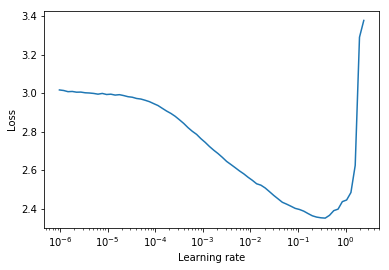

### Useful for other Schedulers

I think the `LRFinder` is also useful for other types of schedulers. Like the plot above, the `lr_finder.plot()` says the suggested LR to be the below.

```markdown
LR suggestion: steepest gradient
Suggested LR: 4.48E-04
```

Notice that they are suggesting the initial LR to be somewhere in between the descent, so do not be fooled and start the LR from the point where it gives the lowest loss >.<|| Doing so will cause your loss to decrease. Intuitively, the LR finder plot just wants you to find a good initial LR, in this case it is indicated by a red dot below, and then as the training progresses (i.e. iter increases can be understood as training progresses), the loss decrease steadily until a point where it is going to diverge, we can choose the end_lr right before that divergence point.


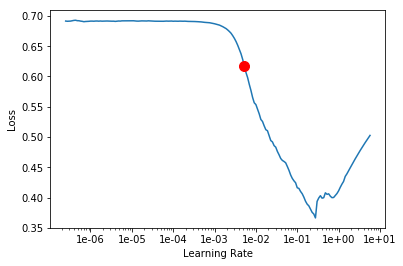 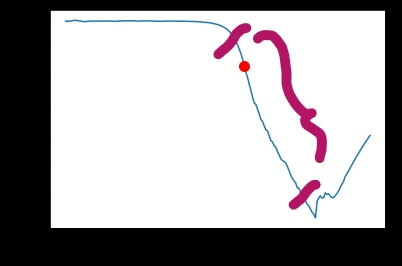


## Metrics

### MetricMonitor

Courtesy of https://www.kaggle.com/manabendrarout/transformers-classifier-method-starter-train.

In [ ]:
# Courtesy of https://www.kaggle.com/manabendrarout/transformers-classifier-method-starter-train
class MetricMonitor:
    """Monitor Metrics"""

    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(
            lambda: {"metric_score": 0, "count": 0, "average_score": 0}
        )

    def update(self, metric_name, metric_score):
        metric = self.metrics[metric_name]

        metric["metric_score"] += metric_score
        metric["count"] += 1
        metric["average_score"] = metric["metric_score"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name,
                    avg=metric["average_score"],
                    float_precision=self.float_precision,
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

### RMSE

Our metric to optimize is a regression metric RMSE.

In [ ]:
import torchmetrics

def mse_torch(y_true: torch.Tensor, y_pred: torch.Tensor, is_rmse: bool = True) -> torch.Tensor:
    """Compute r/mse score for regression.

    Args:
        y_true (torch.Tensor): True labels.
        y_pred (torch.Tensor): Predicted labels.
        is_rmse (bool): Whether return mse or rmse.

    Returns:
        squared_error (torch.Tensor): The squared error
    """
    
    squared = True if is_rmse is False else False
    squared_error = torchmetrics.MeanSquaredError(squared=squared)(y_pred, y_true)
    
    return squared_error


# ====================================================
# Loss
# ====================================================
class RMSELoss(torch.nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss

### CV Metrics

## Trainer

### Optimizer, Scheduler and Criterion

The 3 brothers are always together. We can put them in our big boy `Trainer` class and since `criterion` does not invoke `self` inside these methods, we can put them as `staticmethod`.

### The Trainer

Although very common to see this class named as Trainer, it still reminds me of Pokemon Trainer everytime I invoke this class.

In [ ]:
import time
from pathlib import Path
from typing import DefaultDict, Dict, List, Union

import numpy as np
import torch

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from tqdm.auto import tqdm
import os



class Trainer:
    """Object used to facilitate training."""

    def __init__(
        self,
        params,
        model,
        device=torch.device("cpu"),
        wandb_run=None,
        early_stopping = None,
    ):
        # Set params
        self.params = params
        self.model = model
        self.device = device


        self.wandb_run = wandb_run
        self.early_stopping = early_stopping

        self.optimizer = self.get_optimizer(model=self.model, optimizer_params=OPTIMIZER_PARAMS)
        self.scheduler = self.get_scheduler(optimizer=self.optimizer, scheduler_params=SCHEDULER_PARAMS)
        
        if self.params.use_amp:
            # https://pytorch.org/docs/stable/notes/amp_examples.html
            self.scaler = torch.cuda.amp.GradScaler()
            
        self.monitored_metric = {
        "metric_name": "valid_rmse",
        "metric_score": None,
        "mode": "min",
                    }
        # Metric to optimize, either min or max.
        self.best_valid_score = (
            -np.inf if self.monitored_metric["mode"] == "max" else np.inf
        )
        
        self.patience_counter = self.params.patience  # Early Stopping Counter
        
        # list to contain various train metrics
        # TODO: how to add more metrics? wandb log too. Maybe save to model artifacts?
        self.history = DefaultDict(list)
         
            
    def get_optimizer(self,
        model: CustomNeuralNet,
        optimizer_params: OptimizerParams(),
    ):
        """Get the optimizer for the model.

        Args:
            model (models.CustomNeuralNet): [description]
            optimizer_params (global_params.OptimizerParams): [description]

        Returns:
            [type]: [description]
        """
        return getattr(torch.optim, optimizer_params.optimizer_name)(
            self.model.parameters(), **optimizer_params.optimizer_params
        )


    def get_scheduler(self,
        optimizer: torch.optim,
        scheduler_params: SchedulerParams(),
    ):
        """Get the scheduler for the optimizer.

        Args:
            optimizer (torch.optim): [description]
            scheduler_params (global_params.SchedulerParams(), optional): [description]. Defaults to SCHEDULER_PARAMS.scheduler_params.

        Returns:
            [type]: [description]
        """

        return getattr(torch.optim.lr_scheduler, scheduler_params.scheduler_name)(
            optimizer=self.optimizer, **scheduler_params.scheduler_params
        )

    @staticmethod
    def train_criterion(y_true, y_logits, criterion: CriterionParams()):
        """Train Loss Function.
        Note that we can evaluate train and validation fold with different loss functions.

        The below example applies for CrossEntropyLoss.

        Args:
            y_true ([type]): Input - N,C) where N = number of samples and C = number of classes.
            y_logits ([type]): If containing class indices, shape (N) where each value is 0 \leq \text{targets}[i] \leq C-10≤targets[i]≤C−1
                                If containing class probabilities, same shape as the input.

        Returns:
            [type]: [description]
        """

        loss_fn = getattr(torch.nn, criterion.train_criterion_name)(
            **criterion.train_criterion_params
        )
        loss = loss_fn(y_logits, y_true)
        return loss


    @staticmethod
    def valid_criterion(y_true, y_logits, criterion: CriterionParams()):
        """Validation Loss Function.

        Args:
            y_true ([type]): [description]
            y_logits ([type]): [description]

        Returns:
            [type]: [description]
        """
        loss_fn = getattr(torch.nn, criterion.valid_criterion_name)(
            **criterion.valid_criterion_params
        )
        loss = loss_fn(y_logits, y_true)
        return loss

    def get_classification_metrics(
        self,
        y_trues: torch.Tensor,
        y_preds: torch.Tensor,
        y_probs: torch.Tensor,
    ):
        """[summary]

        Args:
            y_trues (torch.Tensor): dtype=[torch.int64], shape=(num_samples, 1); (May be float if using BCEWithLogitsLoss)
            y_preds (torch.Tensor): dtype=[torch.int64], shape=(num_samples, 1);
            y_probs (torch.Tensor): dtype=[torch.float32], shape=(num_samples, num_classes);

        Returns:
            [type]: [description]
        """

        torchmetrics_accuracy = accuracy_score_torch(
            y_trues,
            y_preds,
            num_classes=TRAIN_PARAMS.num_classes,
            threshold=0.5,
        )

        auroc_dict = multiclass_roc_auc_score_torch(
            y_trues,
            y_probs,
            num_classes=TRAIN_PARAMS.num_classes,
        )

        _auroc_all_classes, macro_auc = (
            auroc_dict["auroc_per_class"],
            auroc_dict["macro_auc"],
        )

        # TODO: To check robustness of the code for confusion matrix.
        # macro_cm = metrics.tp_fp_tn_fn_binary(
        #     y_true=y_trues, y_prob=y_probs, class_labels=[0, 1, 2, 3, 4]
        # )

        return {"accuracy": torchmetrics_accuracy, "macro_auroc": macro_auc}
    
    def get_regression_metrics(
        self,
        y_trues: torch.Tensor,
        y_preds: torch.Tensor,
        y_probs: torch.Tensor,
    ):
        ### ONLY FOR THIS COMP YOU NEED TO DENORMALIZE ###
        y_trues = y_trues * 100
        y_probs = y_probs * 100
        mse = mse_torch(y_trues, y_probs, is_rmse=False)
        rmse = mse_torch(y_trues, y_probs, is_rmse=True)
        
        return {"mse": mse, "rmse": rmse}

    def get_lr(self, optimizer) -> float:
        """Get the learning rate of the current epoch.
        Note learning rate can be different for different layers, hence the for loop.
        Args:
            self.optimizer (torch.optim): [description]
        Returns:
            float: [description]
        """
        for param_group in optimizer.param_groups:
            return param_group["lr"]

    def fit(
        self,
        train_loader: torch.utils.data.DataLoader,
        valid_loader: torch.utils.data.DataLoader,
        fold: int = None,
    ):
        """[summary]

        Args:
            train_loader (torch.utils.data.DataLoader): [description]
            val_loader (torch.utils.data.DataLoader): [description]
            fold (int, optional): [description]. Defaults to None.

        Returns:
            [type]: [description]
        """

        # To automatically log gradients
        # self.wandb_run.watch(self.model, log_freq=100)
        self.best_valid_loss = np.inf

        config.logger.info(
            f"\nTraining on Fold {fold} and using {self.params.model_name}\n"
        )

        for _epoch in range(1, self.params.epochs + 1):

            # get current epoch's learning rate
            curr_lr = self.get_lr(self.optimizer)

            ############################ Start of Training #############################

            train_start_time = time.time()

            train_one_epoch_dict = self.train_one_epoch(train_loader)
            train_loss = train_one_epoch_dict["train_loss"]

            # total time elapsed for this epoch
            train_time_elapsed = time.strftime(
                "%H:%M:%S", time.gmtime(time.time() - train_start_time)
            )

            config.logger.info(
                f"[RESULT]: Train. Epoch {_epoch} | Avg Train Summary Loss: {train_loss:.3f} | "
                f"Learning Rate: {curr_lr:.10f} | Time Elapsed: {train_time_elapsed}\n"
            )

            ########################### End of Training #################################

            ########################### Start of Validation #############################

            val_start_time = time.time()  # start time for validation
            valid_one_epoch_dict = self.valid_one_epoch(valid_loader)

            (
                valid_loss,
                valid_trues,
                valid_logits,
                valid_preds,
                valid_probs,
            ) = (
                valid_one_epoch_dict["valid_loss"],
                valid_one_epoch_dict["valid_trues"],
                valid_one_epoch_dict["valid_logits"],
                valid_one_epoch_dict["valid_preds"],
                valid_one_epoch_dict["valid_probs"],
            )

            # total time elapsed for this epoch
            valid_elapsed_time = time.strftime(
                "%H:%M:%S", time.gmtime(time.time() - val_start_time)
            )

            valid_metrics_dict = self.get_regression_metrics(
                valid_trues,
                valid_preds,
                valid_probs,
            )
            
            valid_rmse = valid_metrics_dict["rmse"]
            
            # TODO: Still need save each metric for each epoch into a list history. Rename properly
            # TODO: Log each metric to wandb and log file.
            
            config.logger.info(
                f"[RESULT]: Validation. Epoch {_epoch} | Avg Val Summary Loss: {valid_loss:.3f} | "
                f"Valid RMSE: {valid_rmse:.3f} | "
                f"Time Elapsed: {valid_elapsed_time}\n"
            )
        
            ########################### End of Validation ##############################

            ########################### Start of Wandb #################################
            self.history["epoch"].append(_epoch)
            self.history["valid_loss"].append(valid_loss)
            self.history["valid_rmse"].append(valid_rmse)
            
            self.log_metrics(_epoch, self.history)
            
            ########################### End of Wandb ###################################

            ########################## Start of Early Stopping ##########################
            ########################## Start of Model Saving ############################

            # User has to choose a few metrics to monitor.
            # Here I chose valid_loss and valid_macro_auroc.

            self.monitored_metric["metric_score"] = torch.clone(valid_rmse)


            if self.early_stopping is not None:
                best_score, early_stop = self.early_stopping.should_stop(
                    curr_epoch_score=valid_loss
                )
                self.best_valid_loss = best_score

                if early_stop:
                    config.logger.info("Stopping Early!")
                    break
                # TODO: Add save_model_artifacts here as well.
            else:
                if valid_loss < self.best_valid_loss:
                    self.best_valid_loss = valid_loss

                if self.monitored_metric["mode"] == "max":
                    if (
                        self.monitored_metric["metric_score"]
                        > self.best_valid_score
                    ):
                        self.best_valid_score = self.monitored_metric[
                            "metric_score"
                        ]
                else:
                    if (
                        self.monitored_metric["metric_score"]
                        < self.best_valid_score
                    ):
                        self.best_valid_score = self.monitored_metric[
                            "metric_score"
                        ]
                        # Reset patience counter as we found a new best score
                        patience_counter_ = self.patience_counter

                        model_path = Path(
                            FILES.weight_path, f"{self.params.model_name}"
                        )
                        # create model directory if not exist
                        os.makedirs(model_path, exist_ok=True)

                        self.save_model_artifacts(
                            Path(
                                model_path,
                                f"{self.params.model_name}_best_{self.monitored_metric['metric_name']}_fold_{fold}.pt",
                            ),
                            valid_trues,
                            valid_logits,
                            valid_preds,
                            valid_probs,
                        )

                        config.logger.info(
                            f"\nSaving model with best valid {self.monitored_metric['metric_name']} score: {self.best_valid_score}"
                        )
                    else:    
                        patience_counter_ -= 1
                        config.logger.info(
                            f"Patience Counter {patience_counter_}"
                        )
                        if patience_counter_ == 0:
                            config.logger.info(
                                f"\n\nEarly Stopping, patience reached!\n\nbest valid {self.monitored_metric['metric_name']} score: {self.best_valid_score}"
                            )
                            break
                            
            ########################## End of Early Stopping ############################
            ########################## End of Model Saving ##############################

            ########################## Start of Scheduler ###############################

            if self.scheduler is not None:
                # Special Case for ReduceLROnPlateau
                if isinstance(
                    self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau
                ):
                    self.scheduler.step(self.monitored_metric["metric_score"])
                    
                elif isinstance(self.scheduler, torch.optim.lr_scheduler.OneCycleLR):
                    config.logger.info(f"Using OneCycleLR")
                    pass
                else:
                    self.scheduler.step()

            ########################## End of Scheduler #################################

        ########################## Load Best Model ##################################
        # Load current checkpoint so we can get model's oof predictions, often in the form of probabilities.
        del self.optimizer
        del self.scheduler
        del valid_trues
        del valid_logits
        del valid_preds
        del valid_probs
        
        curr_fold_best_checkpoint = self.load(
            Path(
                model_path,
                f"{self.params.model_name}_best_{self.monitored_metric['metric_name']}_fold_{fold}.pt",
            )
        )
        ########################## End of Load Best Model ###########################

        return curr_fold_best_checkpoint

    def train_one_epoch(
        self, train_loader: torch.utils.data.DataLoader
    ) -> Dict[str, float]:
        """Train one epoch of the model."""

        metric_monitor = MetricMonitor()

        # set to train mode
        self.model.train()
        average_cumulative_train_loss: float = 0.0
        train_bar = tqdm(train_loader)

        # Iterate over train batches
        
        for step, data in enumerate(train_bar, start=1):
            is_mixup = np.random.randint(1, 10) >= 5
            
            if self.params.use_amp:
                if self.params.mixup and is_mixup:
                    # TODO: Implement MIXUP logic. Refer here: https://www.kaggle.com/ar2017/pytorch-efficientnet-train-aug-cutmix-fmix and my https://colab.research.google.com/drive/1sYkKG8O17QFplGMGXTLwIrGKjrgxpRt5#scrollTo=5y4PfmGZubYp
                    inputs, targets = data["X"], data["y"].view(-1, 1)

                    inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, params = TRANSFORMS.mixup_params)
                    inputs, targets_a, targets_b = inputs.to(self.device, non_blocking=True), targets_a.to(self.device, non_blocking=True), targets_b.to(self.device, non_blocking=True)
                else:
                    # unpack
                    inputs = data["X"].to(self.device, non_blocking=True)
                    # .view(-1, 1) if BCELoss
                    targets = data["y"].to(self.device, non_blocking=True).view(-1, 1)
                    
                self.optimizer.zero_grad()
                with torch.cuda.amp.autocast():
                    logits = self.model(inputs) # Forward pass logits
                    batch_size = inputs.shape[0]
                    if self.params.mixup and is_mixup:
                        curr_batch_train_loss=mixup_criterion(torch.nn.BCEWithLogitsLoss(), logits, targets_a, targets_b, lam)
                    else:
                        #criterion = RMSELoss()
                        #curr_batch_train_loss = criterion(logits, targets)
                        curr_batch_train_loss = self.train_criterion(
                            targets,
                            logits,
                            CRITERION_PARAMS,
                        )
                self.scaler.scale(curr_batch_train_loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
                average_cumulative_train_loss += (
                    curr_batch_train_loss.detach().item()
                    - average_cumulative_train_loss
                ) / (step)
                
            else:
                # unpack
                inputs = data["X"].to(self.device, non_blocking=True)
                # .view(-1, 1) if BCELoss
                targets = data["y"].to(self.device, non_blocking=True)
                batch_size = inputs.shape[0]
                logits = self.model(inputs)  # Forward pass logits
                self.optimizer.zero_grad()  # reset gradients
                curr_batch_train_loss = self.train_criterion(
                    targets,
                    logits,
                    CRITERION_PARAMS,
                )
                curr_batch_train_loss.backward()  # Backward pass
                # Update loss metric
                metric_monitor.update("Loss", curr_batch_train_loss.item())
                train_bar.set_description(f"Train. {metric_monitor}")

                self.optimizer.step()  # Update weights using the optimizer

                # Cumulative Loss
                # Batch/Step 1: curr_batch_train_loss = 10 -> average_cumulative_train_loss = (10-0)/1 = 10
                # Batch/Step 2: curr_batch_train_loss = 12 -> average_cumulative_train_loss = 10 + (12-10)/2 = 11 (Basically (10+12)/2=11)
                # Essentially, average_cumulative_train_loss = loss over all batches / batches
                average_cumulative_train_loss += (
                    curr_batch_train_loss.detach().item()
                    - average_cumulative_train_loss
                ) / (step)
                
                
            y_train_prob = logits.sigmoid()
            self.scheduler.step()

        # self.log_weights(step)
        # running loss
        # self.log_scalar("running_train_loss", curr_batch_train_loss.data.item(), step)
        # TODO: Consider enhancement that returns the same dict as valid_one_epoch.
        return {"train_loss": average_cumulative_train_loss}

    # @torch.no_grad
    def valid_one_epoch(
        self, valid_loader: torch.utils.data.DataLoader
    ) -> Dict[str, Union[float, np.ndarray]]:
        """Validate the model on the validation set for one epoch.

        Args:
            valid_loader (torch.utils.data.DataLoader): The validation set dataloader.

        Returns:
            Dict[str, np.ndarray]:
                valid_loss (float): The validation loss for each epoch.
                valid_trues (np.ndarray): The ground truth labels for each validation set. shape = (num_samples, 1)
                valid_logits (np.ndarray): The logits for each validation set. shape = (num_samples, num_classes)
                valid_preds (np.ndarray): The predicted labels for each validation set. shape = (num_samples, 1)
                valid_probs (np.ndarray): The predicted probabilities for each validation set. shape = (num_samples, num_classes)
        """

        self.model.eval()  # set to eval mode
        metric_monitor = MetricMonitor()
        average_cumulative_valid_loss: float = 0.0
        valid_bar = tqdm(valid_loader)

        valid_logits, valid_trues, valid_preds, valid_probs = [], [], [], []

        with torch.no_grad():
            for step, data in enumerate(valid_bar, start=1):
                # unpack
                inputs = data["X"].to(self.device, non_blocking=True)
                targets = data["y"].to(self.device, non_blocking=True).view(-1,1)

                self.optimizer.zero_grad()  # reset gradients

                logits = self.model(inputs)  # Forward pass logits
                # print(f"valid_logits.shape: {logits.shape}")

                # get batch size, may not be same as params.batch_size due to whether drop_last in loader is True or False.
                batch_size = inputs.shape[0]
                # assert targets.size() == (batch_size,)
                # assert logits.size() == (batch_size, TRAIN_PARAMS.num_classes)

                # TODO: Refer to my RANZCR notes on difference between Softmax and Sigmoid with examples.
                y_valid_prob = logits.sigmoid()
                y_valid_pred = torch.argmax(y_valid_prob, axis=1)
             
                #criterion = RMSELoss()
                #curr_batch_val_loss = criterion(logits, targets)
                curr_batch_val_loss = self.valid_criterion(targets, logits, CRITERION_PARAMS)
                
                average_cumulative_valid_loss += (
                    curr_batch_val_loss.item() - average_cumulative_valid_loss
                ) / (step)
                valid_bar.set_description(f"Validation. Loss: {metric_monitor}")

                # For OOF score and other computation.
                # TODO: Consider giving numerical example. Consider rolling back to targets.cpu().numpy() if torch fails.
                valid_trues.extend(targets.cpu())
                valid_logits.extend(logits.cpu())
                valid_preds.extend(y_valid_pred.cpu())
                valid_probs.extend(y_valid_prob.cpu())
        
        # We should work with numpy arrays.
        # vstack here to stack the list of numpy arrays.
        # a = [np.asarray([1,2,3]), np.asarray([4,5,6])]
        # np.vstack(a) -> array([[1, 2, 3], [4, 5, 6]])
        valid_trues, valid_logits, valid_preds, valid_probs = (
            torch.vstack(valid_trues),
            torch.vstack(valid_logits),
            torch.vstack(valid_preds),
            torch.vstack(valid_probs),
        )
        num_valid_samples = len(valid_trues)
        assert valid_trues.shape == valid_preds.shape == (num_valid_samples, 1)
        assert (
            valid_logits.shape
            == valid_probs.shape
            == (num_valid_samples, TRAIN_PARAMS.num_classes)
        )

        return {
            "valid_loss": average_cumulative_valid_loss,
            "valid_trues": valid_trues,
            "valid_logits": valid_logits,
            "valid_preds": valid_preds,
            "valid_probs": valid_probs,
        }

    def log_metrics(
        self, epoch: int, history: Dict[str, Union[float, np.ndarray]]
    ):
        """Log a scalar value to both MLflow and TensorBoard
        Args:
            history (Dict[str, Union[float, np.ndarray]]): A dictionary of metrics to log.
        """
        for metric_name, metric_values in history.items():
            self.wandb_run.log(
                {metric_name: metric_values[epoch - 1]}, step=epoch
            )
        # self.wandb_run.log(history)


    def save_model(self, path: str) -> None:
        """Save the trained model."""
        self.model.eval()
        torch.save(self.model.state_dict(), path)

    def save_model_artifacts(
        self,
        path: str,
        valid_trues: torch.Tensor,
        valid_logits: torch.Tensor,
        valid_preds: torch.Tensor,
        valid_probs: torch.Tensor,
    ) -> None:
        """Save the weight for the best evaluation metric and also the OOF scores.
        valid_trues -> oof_trues: np.array of shape [num_samples, 1] and represent the true labels for each sample in current fold.
                                i.e. oof_trues.flattened()[i] = true label of sample i in current fold.
        valid_logits -> oof_logits: np.array of shape [num_samples, num_classes] and represent the logits for each sample in current fold.
                                i.e. oof_logits[i] = [logit_of_sample_i_in_current_fold_for_class_0, logit_of_sample_i_in_current_fold_for_class_1, ...]
        valid_preds -> oof_preds: np.array of shape [num_samples, 1] and represent the predicted labels for each sample in current fold.
                                i.e. oof_preds.flattened()[i] = predicted label of sample i in current fold.
        valid_probs -> oof_probs: np.array of shape [num_samples, num_classes] and represent the probabilities for each sample in current fold. i.e. first row is the probabilities of the first class.
                                i.e. oof_probs[i] = [probability_of_sample_i_in_current_fold_for_class_0, probability_of_sample_i_in_current_fold_for_class_1, ...]
        """
        # self.model.eval()

        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "scheduler_state_dict": self.scheduler.state_dict(),
                "oof_trues": valid_trues,
                "oof_logits": valid_logits,
                "oof_preds": valid_preds,
                "oof_probs": valid_probs,
            },
            path,
        )

    @staticmethod
    def load(path: str):
        """Load a model checkpoint from the given path.
        Reason for using a static method: https://stackoverflow.com/questions/70052073/am-i-using-static-method-correctly/70052107#70052107
        """
        checkpoint = torch.load(path, map_location=torch.device("cpu"))
        return checkpoint


## Weights & Biases

> Not an ambassador, but I guess marketing down right is how I would describe this company. There are many MLOps platform, but W&B has so many example notebooks online so I conveniently copy what others do. After all, it is much easier to stand on the shoulders of giants :)

In [ ]:
# ====================================================
# wandb
# ====================================================

if not is_inference:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    wandb_api = user_secrets.get_secret("Petfinder")

    import wandb
    wandb.login(key=wandb_api)
    

def wandb_init(fold: int):
    config = {
        "Train_Params": TRAIN_PARAMS.to_dict(),
        "Model_Params": MODEL_PARAMS.to_dict(),
    }
    wandb_run = wandb.init(
        config=config,
        name=f"{TRAIN_PARAMS.model_name}_fold_{fold}",
        **WANDB_PARAMS.to_dict(),
    )
    return wandb_run

In [ ]:
def train_one_fold(df_folds: pd.DataFrame, fold: int, is_plot: bool = False):
    """Train the model on the given fold."""

    ################################## W&B #####################################
    # wandb.login()
    wandb_run = wandb_init(fold=fold)

    train_loader, valid_loader, df_oof = prepare_loaders(df_folds, fold)

    if is_plot:
        image_grid = plot.show_image(
            loader=train_loader,
            nrows=1,
            ncols=1,
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        )
        # writer.add_image("name", image_grid)

    # Model, cost function and optimizer instancing
    # model = CustomNeuralNet().to(device)
    model = dognet

    reighns_trainer: Trainer = Trainer(
        params=TRAIN_PARAMS,
        model=model,
        device=device,
        wandb_run=wandb_run,
    )

    curr_fold_best_checkpoint = reighns_trainer.fit(
        train_loader, valid_loader, fold
    )

    # TODO: Note that for sigmoid on one class, the OOF score is the positive class.
    df_oof[[str(c) + "_oof" for c in range(TRAIN_PARAMS.num_classes)]] = (
        curr_fold_best_checkpoint["oof_probs"].detach().numpy()
    )
    df_oof["oof_trues"] = curr_fold_best_checkpoint["oof_trues"]
    # df_oof['error_analysis'] = todo - sort the dataframe by the ones that the model got wrong to see where they are focusing.
    # df_oof["oof_preds"] = curr_fold_best_checkpoint["oof_preds"].argmax(1)

    df_oof.to_csv(Path(FILES.oof_csv, f"oof_fold_{fold}.csv"), index=False)
    del model

    gc.collect()
    torch.cuda.empty_cache()

    wandb_run.finish()  # Finish the run to start next fold.

    return df_oof


def train_loop(df_folds: pd.DataFrame, is_plot: bool = False):
    """Perform the training loop on all folds. Here The CV score is the average of the validation fold metric.
    While the OOF score is the aggregation of all validation folds."""

    cv_score_list = []
    df_oof = pd.DataFrame()

    for fold in range(1, FOLDS.num_folds + 1):
        if fold == 1:
            _df_oof = train_one_fold(df_folds=df_folds, fold=fold, is_plot=is_plot)
            df_oof = pd.concat([df_oof, _df_oof])

        # TODO: populate the cv_score_list using a dataframe like breast cancer project.
        # curr_fold_best_score_dict, curr_fold_best_score = get_oof_roc(config, _oof_df)
        # cv_score_list.append(curr_fold_best_score)
        # print("\n\n\nOOF Score for Fold {}: {}\n\n\n".format(fold, curr_fold_best_score))

    # print("CV score", np.mean(cv_score_list))
    # print("Variance", np.var(cv_score_list))
    # print("Five Folds OOF", get_oof_roc(config, oof_df))

    df_oof.to_csv(Path(FILES.oof_csv, "oof.csv"), index=False)
    return df_oof

The idea of normalizing the targets to between 0 and 1 is to conform to the idea of using BinaryCrossEntropy Loss. Technically, our target should only be 0 or 1 in a "binary setting", but we are pulling a sleight of hands to still treat the problem as a classification problem, and although if you predict a label with 100% probability and the label is indeed 1, your BCE loss will be 0, but it will not be the same here, but regardless, if your target is 0.6, and your prediction is 0.6, then the loss will be guaranteed to be the lowest if it predicts anything other than 0.6, though it won't be 0.

In [ ]:
# Examples:

loss = torch.nn.BCEWithLogitsLoss()
input = torch.tensor([0.6])
target = torch.tensor([0.6])
output = loss(input, target)
print(output) # -> this should be the minimum of the loss function if the prediction==target if I am not wrong.

## Inference

In [ ]:
def inference_all_folds(
    model: CustomNeuralNet,
    state_dicts: List[collections.OrderedDict],
    test_loader: torch.utils.data.DataLoader,
) -> np.ndarray:
    """Inference the model on all K folds.
    Args:
        model (models.CustomNeuralNet): The model to be used for inference. Note that pretrained should be set to False.
        state_dicts (List[collections.OrderedDict]): The state dicts of the models. Generally, K Fold means K state dicts.
        test_loader (torch.utils.data.DataLoader): The dataloader for the test set.
    Returns:
        mean_cv_preds (np.ndarray): The mean of the predictions of all folds.
    """

    model.to(device)
    model.eval()

    with torch.no_grad():
        all_folds_preds = []

        for _fold_num, state in enumerate(state_dicts):
            if "model_state_dict" not in state:
                model.load_state_dict(state)
            else:
                model.load_state_dict(state["model_state_dict"])

            current_fold_preds = []

            for data in tqdm(test_loader, position=0, leave=True):
                images = data["X"].to(device)
                logits = model(images)
                y_test_prob = logits.sigmoid().cpu().numpy()
                # Need to multiply the predictions by 100 since we divide by 100 in the training script.
                y_test_prob = y_test_prob * 100

                current_fold_preds.append(y_test_prob)

            current_fold_preds = np.concatenate(current_fold_preds, axis=0)
            all_folds_preds.append(current_fold_preds)
        mean_cv_preds = np.mean(all_folds_preds, axis=0)
    return mean_cv_preds


def inference(
    df_test: pd.DataFrame,
    model_dir: str,
    df_sub: pd.DataFrame = None,
) -> Dict[str, np.ndarray]:
    """Inference the model and perform TTA, if any.
    Dataset and Dataloader are constructed within this function because of TTA.
    Args:
        df_test (pd.DataFrame): The test dataframe.
        model_dir (str): model directory for the model.
        df_sub (pd.DataFrame, optional): The submission dataframe. Defaults to None.
    Returns:
        all_preds (Dict[str, np.ndarray]): {"normal": normal_preds, "tta": tta_preds}
    """
    # Model, cost function and optimizer instancing

    model = CustomNeuralNet(pretrained=False).to(device)

    all_preds = {}
    transform_dict = get_inference_transforms()

    # weights = [model_path for model_path in glob.glob(model_dir + "/*.pt")]
    weights = [
        "../input/petfinder-flexible-pytorch-pipeline/model/swin_large_patch4_window7_224/swin_large_patch4_window7_224_best_valid_rmse_fold_1.pt",
        "../input/petfinder-flexible-pytorch-pipeline/model/swin_large_patch4_window7_224/swin_large_patch4_window7_224_best_valid_rmse_fold_2.pt",
        "../input/petfinder-flexible-pytorch-pipeline/model/swin_large_patch4_window7_224/swin_large_patch4_window7_224_best_valid_rmse_fold_3.pt",
        "../input/petfinder-flexible-pytorch-pipeline/model/swin_large_patch4_window7_224/swin_large_patch4_window7_224_best_valid_rmse_fold_4.pt",
        "../input/petfinder-flexible-pytorch-pipeline/model/swin_large_patch4_window7_224/swin_large_patch4_window7_224_best_valid_rmse_fold_5.pt"
    ]
    state_dicts = [torch.load(path)["model_state_dict"] for path in weights]


    for aug, aug_param in transform_dict.items():
        test_dataset = CustomDataset(
            df=df_test, transforms=aug_param, mode="test"
        )
        test_loader = torch.utils.data.DataLoader(
            test_dataset, **LOADER_PARAMS.test_loader
        )
        predictions = inference_all_folds(
            model=model, state_dicts=state_dicts, test_loader=test_loader
        )

        all_preds[aug] = predictions

        df_sub[FOLDS.class_col_name] = predictions # np.argmax(predictions, axis=1)
        
        df_sub[[FOLDS.image_col_name, FOLDS.class_col_name]].to_csv(
            f"submission.csv", index=False
        )
        
        df_sub.head()

        plt.figure(figsize=(12, 6))
        plt.hist(df_sub[FOLDS.class_col_name], bins=100)
    
#     df_sub[FOLDS.class_col_name] = all_preds["transforms_test"] * 0.5 + all_preds["tta_hflip"] * 0.5
#     df_sub[[FOLDS.image_col_name, FOLDS.class_col_name]].to_csv(
#     f"submission.csv", index=False
#     )
        
    return all_preds

## Inference with SVR

In [ ]:
# def inference_all_folds(
#     model: CustomNeuralNet,
#     state_dicts: List[collections.OrderedDict],
#     test_loader: torch.utils.data.DataLoader,
#     svr_state_dicts = None
# ) -> np.ndarray:
#     """Inference the model on all K folds.
#     Args:
#         model (models.CustomNeuralNet): The model to be used for inference. Note that pretrained should be set to False.
#         state_dicts (List[collections.OrderedDict]): The state dicts of the models. Generally, K Fold means K state dicts.
#         test_loader (torch.utils.data.DataLoader): The dataloader for the test set.
#     Returns:
#         mean_cv_preds (np.ndarray): The mean of the predictions of all folds.
#     """

#     model.to(device)
#     model.eval()

#     with torch.no_grad():
#         all_folds_preds = []
#         all_folds_svr_preds = []

#         for _fold_num, (state, svr_state) in enumerate(zip(state_dicts, svr_state_dicts)):
#             if "model_state_dict" not in state:
#                 model.load_state_dict(state)
#             else:
#                 model.load_state_dict(state["model_state_dict"])
            

#             ##################
#             # LOAD RAPIDS SVR 
#             print('Loading SVR...')
#             svr = pickle.load(open(svr_state, "rb"))

#             current_fold_preds = []
#             current_fold_svr_preds = []

#             for data in tqdm(test_loader, position=0, leave=True):
#                 images = data["X"].to(device)
#                 # Additional steps for SVR
#                 embeddings = model.extract_features(images)
#                 svr_preds = svr.predict(embeddings.cpu().numpy())
#                 logits = model(images)
#                 y_test_prob = logits.sigmoid().cpu().numpy()
#                 # Need to multiply the predictions by 100 since we divide by 100 in the training script.
#                 y_test_prob = y_test_prob * 100

#                 current_fold_preds.append(y_test_prob)
#                 current_fold_svr_preds.append(svr_preds)

#             current_fold_preds = np.concatenate(current_fold_preds, axis=0)
#             current_fold_svr_preds = np.concatenate(current_fold_svr_preds, axis=0)
#             all_folds_preds.append(current_fold_preds)
#             all_folds_svr_preds.append(current_fold_svr_preds)
#         mean_cv_preds = np.mean(all_folds_preds, axis=0)
#         mean_cv_svr_preds = np.mean(all_folds_svr_preds, axis=0)
#     return mean_cv_preds, mean_cv_svr_preds


# def inference(
#     df_test: pd.DataFrame,
#     model_dir: str,
#     df_sub: pd.DataFrame = None,
# ) -> Dict[str, np.ndarray]:
#     """Inference the model and perform TTA, if any.
#     Dataset and Dataloader are constructed within this function because of TTA.
#     Args:
#         df_test (pd.DataFrame): The test dataframe.
#         model_dir (str): model directory for the model.
#         df_sub (pd.DataFrame, optional): The submission dataframe. Defaults to None.
#     Returns:
#         all_preds (Dict[str, np.ndarray]): {"normal": normal_preds, "tta": tta_preds}
#     """
#     # Model, cost function and optimizer instancing

#     model = CustomNeuralNet(pretrained=False).to(device)

#     all_preds = {}
#     transform_dict = get_inference_transforms()

#     # weights = [model_path for model_path in glob.glob(model_dir + "/*.pt")]
    
#     weights = ["../input/swin-large-petfinder-hn/swin_large_patch4_window7_224_best_valid_rmse_fold_1.pt",
#               "../input/swin-large-petfinder-hn/swin_large_patch4_window7_224_best_valid_rmse_fold_2.pt",
#               "../input/swin-large-petfinder-hn/swin_large_patch4_window7_224_best_valid_rmse_fold_3.pt",
#               "../input/swin-large-petfinder-hn/swin_large_patch4_window7_224_best_valid_rmse_fold_4.pt",
#               "../input/swin-large-petfinder-hn/swin_large_patch4_window7_224_best_valid_rmse_fold_5.pt"]

#     SVR_weights = ["../input/swin-large-petfinder-hn/SVR_fold_1.pkl", 
#                    "../input/swin-large-petfinder-hn/SVR_fold_2.pkl", 
#                    "../input/swin-large-petfinder-hn/SVR_fold_3.pkl", 
#                    "../input/swin-large-petfinder-hn/SVR_fold_4.pkl", 
#                    "../input/swin-large-petfinder-hn/SVR_fold_5.pkl"]
    
#     state_dicts = [torch.load(path)["model_state_dict"] for path in weights]

#     for aug, aug_param in transform_dict.items():
#         test_dataset = CustomDataset(
#             df=df_test, transforms=aug_param, mode="test"
#         )
#         test_loader = torch.utils.data.DataLoader(
#             test_dataset, **LOADER_PARAMS.test_loader
#         )
#         predictions, svr_predictions = inference_all_folds(
#             model=model, 
#             state_dicts=state_dicts,
#             test_loader=test_loader, 
#             svr_state_dicts=SVR_weights
#         )
        
        
#         all_preds[aug] = predictions * 0.8 + svr_predictions * 0.2

#         df_sub[FOLDS.class_col_name] = predictions * 0.8 + svr_predictions * 0.2 # np.argmax(predictions, axis=1)

#         df_sub[[FOLDS.image_col_name, FOLDS.class_col_name]].to_csv(
#             f"submission.csv", index=False
#         )
#         df_sub.head()

#         plt.figure(figsize=(12, 6))
#         plt.hist(df_sub[FOLDS.class_col_name], bins=100)
#     return all_preds

## SVR Head Fitting/Training

In [ ]:
import cuml, pickle
from cuml.svm import SVR
print('RAPIDS version',cuml.__version__,'\n')

# NUM_DENSE = 0

# LOAD_SVR_FROM_PATH = "../input/swin-large-petfinder-hn/"
# # If training define LOAD_SVR_FROM_PATH = None


# super_final_predictions = []
# super_final_predictions2 = []
# super_final_oof_predictions = []
# super_final_oof_predictions2 = []
# super_final_oof_true = []
# batch_size = 4
# # weights = [model_path for model_path in glob.glob(model_dir + "/*.pt")]

# weights = ["../input/swin-large-petfinder-hn/swin_large_patch4_window7_224_best_valid_rmse_fold_1.pt",
#           "../input/swin-large-petfinder-hn/swin_large_patch4_window7_224_best_valid_rmse_fold_2.pt",
#           "../input/swin-large-petfinder-hn/swin_large_patch4_window7_224_best_valid_rmse_fold_3.pt",
#           "../input/swin-large-petfinder-hn/swin_large_patch4_window7_224_best_valid_rmse_fold_4.pt",
#           "../input/swin-large-petfinder-hn/swin_large_patch4_window7_224_best_valid_rmse_fold_5.pt"]
    

# # Utimately we want embeddings to be shape (n_samples, n_embeddings)
# # SO in my case if n_embeddings=1536, then if 100 samples, our final shape is (100, 1536)
# for index, fold_ in enumerate(range(1, FOLDS.num_folds+1)):
#     svr_name = f"SVR_fold_{fold_}.pkl"
#     print('#'*25)
#     print('### FOLD',fold_)
#     print('#'*25)
#     if LOAD_SVR_FROM_PATH is None:
#         df_valid = df_folds[df_folds["fold"] != fold_].reset_index(drop=True)
#         # Here hard code the embeddings first, as ultimately we want (n_samples, 1536)
#         embeddings = torch.zeros(df_valid.shape[0], 1536)

#         model = CustomNeuralNet(pretrained=False).to(device)

#         valid_transforms = get_inference_transforms()["transforms_test"]

#         state_dict = torch.load(weights[index])["model_state_dict"]
#         model.load_state_dict(state_dict)
#         model.eval() # Think if u extract embeddings should set to eval too

#         valid_dataset = CustomDataset(
#             df=df_valid, transforms=valid_transforms, mode="train"
#         )
#         valid_loader = torch.utils.data.DataLoader(
#             valid_dataset, shuffle=False, batch_size = batch_size
#         )
#         row, col = 0, batch_size
#         with torch.no_grad():
#             for data in tqdm(valid_loader, position=0, leave=True):
#                 images = data["X"].to(device)
#                 targets = data["y"].to(device)
#                 # SWIN returns 1536 as embeddings, depends on how you take it it can be flattened or not yet
#                 curr_batch_embeds = model.extract_features(images)
#                 embeddings[row:col] = curr_batch_embeds
#                 row, col = row + batch_size, col + batch_size


#         ##################
#         # FIT RAPIDS SVR
#         print('Fitting SVR...')
#         clf = SVR(C=20.0)
#         clf.fit(embeddings.cpu().detach().numpy().astype('float32'), df_valid.Pawpularity.values.astype('int32'))

#         ##################
#         # SAVE RAPIDS SVR 
#         pickle.dump(clf, open(svr_name, "wb"))

In [ ]:
from sklearn import metrics

def calc_oof(y_true, y_pred):
    """
    Calculate out of fold metric
    """
    rmse = metrics.mean_squared_error(y_true, y_pred, squared=False)
    return rmse

In [ ]:
if __name__ == "__main__":
    if not is_inference:
        df_oof = train_loop(df_folds=df_folds, is_plot=False)
        oof_cv = calc_oof(df_oof["oof_trues"].values, df_oof["0_oof"].values)
        config.logger.info(f"OOF RMSE: {oof_cv}")
        torch.cuda.empty_cache()
    else:
        model_dir = r"C:\Users\reighns\kaggle_projects\cassava\model\tf_efficientnet_b0_ns"
        predictions = inference(df_test, model_dir, df_sub)
        # _ = inference.show_gradcam()